# Sliding time window laminar model comparison using free energy

This tutorial demonstrates how to perform laminar inference of event-related responses in a sliding time window using model comparison based on free energy as a metric of model fit, described in [Bonaiuto et al., 2021, Laminar dynamics of high amplitude beta bursts in human motor cortex](https://doi.org/10.1016/j.neuroimage.2021.118479). A temporal Gaussian function is simulated at a particular cortical location in various layers. Source reconstruction is performed on the whole time window using the Empirical Bayesian Beamformer on the simulated sensor data using a forward model based on the multilayer mesh as a localizer. This is used to select priors on each layer mesh for a sliding time window model comparison using free energy.

## Setting up the simulations

Simulations are based on an existing dataset, which is used to define the sampling rate, number of trials, duration of each trial, and the channel layout.

In [2]:
import os
import shutil
import numpy as np
import nibabel as nib
from matplotlib import colors
import matplotlib.pyplot as plt

from lameg.invert import coregister, invert_ebb, load_source_time_series
from lameg.laminar import sliding_window_model_comparison
from lameg.simulate import run_dipole_simulation
from lameg.surf import interpolate_data
from lameg.util import get_surface_names
from lameg.viz import show_surface, color_map
import spm_standalone

# Subject information for data to base the simulations on
subj_id = 'sub-104'
ses_id = 'ses-01'

# Fiducial coil coordinates
nas = [0.9662503311032098, 108.83514306876269, 1.6712361927090313]
lpa = [-74.28671169006893, 20.15061014698176, -29.849056272705948]
rpa = [76.02110531729883, 18.9467849625573, -25.779407159603114]

# Data file to base simulations on
data_file = os.path.join(
    '../test_data', 
    subj_id, 
    'meg',
    ses_id, 
    'spm/pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat'
)

spm = spm_standalone.initialize()

For source reconstructions, we need an MRI and a surface mesh. The simulations will be based on a forward model using the multilayer mesh, and the model comparison will use each layer mesh

In [3]:
# Native space MRI to use for coregistration
mri_fname = os.path.join('../test_data', subj_id, 'mri/s2023-02-28_13-33-133958-00001-00224-1.nii' )

# Mesh to use for forward model in the simulations
multilayer_mesh_fname = os.path.join('../test_data', subj_id, 'surf/multilayer.11.ds.link_vector.fixed.gii')

# Load multilayer mesh and compute the number of vertices per layer
mesh = nib.load(multilayer_mesh_fname)
n_layers = 11
verts_per_surf = int(mesh.darrays[0].data.shape[0]/n_layers)

# Get name of each mesh that makes up the layers of the multilayer mesh - these will be used for the source 
# reconstruction
layer_fnames = get_surface_names(
    n_layers, 
    os.path.join('../test_data', subj_id, 'surf'), 
    'link_vector.fixed'
)

# Inflated meshes for plotting
ds_inflated = nib.load(os.path.join('../test_data', subj_id, 'surf', 'inflated.ds.gii'))
orig_inflated = nib.load(os.path.join('../test_data', subj_id, 'surf', 'inflated.gii'))

We're going to copy the data file to a temporary directory and direct all output there.

In [4]:
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Where to put simulated data
tmp_dir = '/scratch/bonaiuto/simulated_data/sliding_window'

# Copy data files to tmp directory
shutil.copy(
    os.path.join(data_path, f'{data_base}.mat'), 
    os.path.join(tmp_dir, f'{data_base}.mat')
)
shutil.copy(
    os.path.join(data_path, f'{data_base}.dat'), 
    os.path.join(tmp_dir, f'{data_base}.dat')
)

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')

Invert the subject's data using the multilayer mesh. This step only has to be done once - this is just to compute the forward model that will be used in the simulations

In [5]:
# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size = 5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    multilayer_mesh_fname, 
    base_fname,
    spm_instance=spm
)

# Run inversion
[_,_] = invert_ebb(
    multilayer_mesh_fname, 
    base_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    spm_instance=spm
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st2/spm_standalo/lameg/matlab/spm_my_defaults.m
Modified fields: use_parfor mat 
Initialising batch system... done.


------------------------------------------------------------------------
13-Jul-2024 08:56:22 - Running job #1
------------------------------------------------------------------------
13-Jul-2024 08:56:22 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           08:56:22 - 13/07/2024
multilayer.11.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for

## Simulating a signal on the pial surface
We're going to simulate 200ms of a Gaussian with a dipole moment of 5nAm and a width of 25ms

Text(0, 0.5, 'Amplitude (nAm)')

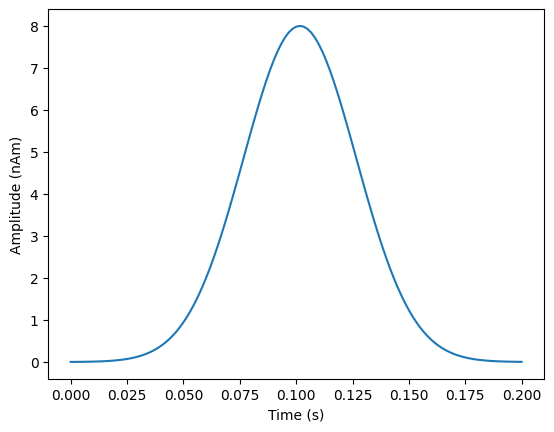

In [6]:
# Strength of simulated activity (nAm)
dipole_moment = 8
# Temporal width of the simulated Gaussian
signal_width=.025 # 25ms
# Sampling rate (must match the data file)
s_rate = 600

# Generate 200ms of a Gaussian at a sampling rate of 600Hz (to match the data file)
time=np.linspace(0,.2,121)
zero_time=time[int((len(time)-1)/2+1)]
sim_signal=np.exp(-((time-zero_time)**2)/(2*signal_width**2)).reshape(1,-1)
plt.plot(time,dipole_moment*sim_signal[0,:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

We need to pick a location (mesh vertex) to simulate at

In [7]:
# Vertex to simulate activity at
sim_vertex=24588

pial_ds_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'pial.ds.link_vector.fixed.gii')
pial_ds_mesh = nib.load(pial_ds_mesh_fname)
pial_coord = pial_ds_mesh.darrays[0].data[sim_vertex,:]
pial_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'pial.gii')
pial_mesh = nib.load(pial_mesh_fname)
cam_view = [152, 28, 15,
            3.5, 26, 38.5,
            0, 0, 1]
plot = show_surface(
    pial_mesh, 
    opacity=1, 
    coords=pial_coord,
    coord_size=2,
    camera_view=cam_view
)

Output()

We'll simulate a 5mm patch of activity with -5 dB SNR at the sensor level. The desired level of SNR is achieved by adding white noise to the projected sensor signals

In [8]:
# Simulate at a vertex on the pial surface
pial_vertex = sim_vertex
# Orientation of the simulated dipole
pial_unit_norm = mesh.darrays[2].data[pial_vertex,:]
prefix = f'sim_{sim_vertex}_pial_'

# Size of simulated patch of activity (mm)
sim_patch_size = 5
# SNR of simulated data (dB)
SNR = -10

# Generate simulated data
pial_sim_fname = run_dipole_simulation(
    base_fname, 
    prefix, 
    pial_vertex, 
    sim_signal, 
    pial_unit_norm, 
    dipole_moment, 
    sim_patch_size, 
    SNR,
    spm_instance=spm
) 

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING DIPOLE SOURCES
computing surface normals
Setting white noise to give sensor level SNR of -10B

 Finish


## Localizer inversion
Now we'll run a source reconstruction using the multilayer mesh, extract the signal in the pial layer, and select a prior based on the peak.

In [9]:
[_,_,MU] = invert_ebb(
    multilayer_mesh_fname, 
    pial_sim_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    return_mu_matrix=True,
    spm_instance=spm
)

layer_vertices = np.arange(verts_per_surf)
layer_ts, time, ch_names = load_source_time_series(
    pial_sim_fname, 
    mu_matrix=MU, 
    vertices=layer_vertices
)

# Layer peak
m_layer_max = np.max(np.mean(layer_ts,axis=-1),-1)
prior = np.argmax(m_layer_max)

sim_coord = ds_inflated.darrays[0].data[sim_vertex,:]
prior_coord = ds_inflated.darrays[0].data[prior,:]

print(f'Simulated vertex={sim_vertex}, Prior vertex={prior}')
print('Simulated coordinate')
print(sim_coord)
print('Prior coordinate')
print(prior_coord)

Smoothing ../test_data/sub-104/surf/multilayer.11.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/sliding_window/sim_24588_pial_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st2/spm_standalo/lameg/matlab/spm_my_defaults.m
Modified fields: use_parfor mat 


-----------------------------------

We can see that the prior is the same as the location we simulated at

In [11]:
# Interpolate for display on the original inflated surface
interpolated_data = interpolate_data(orig_inflated, ds_inflated, m_layer_max)
          
# Plot colors and camera view
max_abs = np.max(np.abs(m_layer_max))
c_range = [-max_abs, max_abs]
cam_view=[289, 32, -19,
          3.5, 29, 26,
          0, 0, 1]

# Plot peak
colors,_ = color_map(
    interpolated_data, 
    "RdYlBu_r", 
    c_range[0], 
    c_range[1]    
)

plot = show_surface(
    orig_inflated, 
    vertex_colors=colors, 
    info=True, 
    camera_view=cam_view, 
    coords=prior_coord, 
    coord_size=2, 
    coord_color=[0,0,255]
)

Output()

507832 vertices


## Sliding time window model comparison (pial - white matter)
Now we can run sliding time window model comparison between source models based on the pial and white matter surfaces using free energy. Specifically, we'll look at the difference in free energy between the two models (pial - white matter), in sliding and overlapping windows of 16ms. The free energy difference (pial - white matter) should be positive (more model evidence for the pial surface model) because we simulated activity on the pial surface.

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st2/spm_standalo/lameg/matlab/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
13-Jul-2024 09:26:36 - Running job #1
------------------------------------------------------------------------
13-Jul-2024 09:26:36 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           09:26:52 - 13/07/2024
pial.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for the gradiometer definition
creating layout 

  ReML Iteration              : 13                            ...4.005133e+00
  ReML Iteration              : 14                            ...2.216189e+00
  ReML Iteration              : 15                            ...1.175926e+00
  ReML Iteration              : 16                            ...6.042991e-01
  ReML Iteration              : 17                            ...3.034564e-01
  ReML Iteration              : 18                            ...1.500547e-01
  ReML Iteration              : 19                            ...7.353653e-02
  ReML Iteration              : 20                            ...3.590163e-02
  ReML Iteration              : 21                            ...1.753178e-02
  ReML Iteration              : 22                            ...8.588428e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220741e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192805e+02 [+4.25]
  ReML Iteration 3    

log evidence & hyperparameters:
    0.00   -0.06
   11.12   -1.77

  ReML Iteration              : 1                            ...1.086544e+02
  ReML Iteration              : 2                            ...8.517317e+01
  ReML Iteration              : 3                            ...7.197638e+01
  ReML Iteration              : 4                            ...6.264175e+01
  ReML Iteration              : 5                            ...5.486672e+01
  ReML Iteration              : 6                            ...4.758103e+01
  ReML Iteration              : 7                            ...4.027456e+01
  ReML Iteration              : 8                            ...3.282877e+01
  ReML Iteration              : 9                            ...2.545991e+01
  ReML Iteration              : 10                            ...1.861467e+01
  ReML Iteration              : 11                            ...1.277286e+01
  ReML Iteration              : 12                            ...8.234683e+00
  ReML

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219007e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194491e+02 [+4.25]
  ReML Iteration 3                      :        ...1.172116e+02 [+4.38]
  ReML Iteration 4                      :        ...1.118043e+02 [+4.50]
  ReML Iteration 5                      :        ...2.972909e-05 [+4.62]
Percent variance explained -18.21 (-9.66)
Number of samples 22
Fixed number of temporal modes
Using 4 temporal modes, accounting for 53.06 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.820859e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188790e+02 [+4.25]
  ReML Iteratio

  ReML Iteration              : 7                            ...4.020899e+01
  ReML Iteration              : 8                            ...3.274940e+01
  ReML Iteration              : 9                            ...2.537221e+01
  ReML Iteration              : 10                            ...1.852684e+01
  ReML Iteration              : 11                            ...1.269321e+01
  ReML Iteration              : 12                            ...8.168793e+00
  ReML Iteration              : 13                            ...4.969935e+00
  ReML Iteration              : 14                            ...2.888135e+00
  ReML Iteration              : 15                            ...1.623207e+00
  ReML Iteration              : 16                            ...8.944205e-01
  ReML Iteration              : 17                            ...4.905086e-01
  ReML Iteration              : 18                            ...2.726371e-01
  ReML Iteration              : 19                            ...1.

Percent variance explained -82.55 (-36.97)
Number of samples 28
Fixed number of temporal modes
Using 4 temporal modes, accounting for 41.40 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.830828e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187986e+02 [+4.25]
  ReML Iteration 3                      :        ...1.130336e+02 [+4.38]
  ReML Iteration 4                      :        ...1.037951e+02 [+4.50]
  ReML Iteration 5                      :        ...8.333465e+01 [+4.62]
  ReML Iteration 6                      :        ...4.945520e-04 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
   11.12   -1.76

  ReML Iteration              : 1                            ...1.086344

  ReML Iteration              : 1                            ...1.086562e+02
  ReML Iteration              : 2                            ...8.517672e+01
  ReML Iteration              : 3                            ...7.198252e+01
  ReML Iteration              : 4                            ...6.265158e+01
  ReML Iteration              : 5                            ...5.488150e+01
  ReML Iteration              : 6                            ...4.760187e+01
  ReML Iteration              : 7                            ...4.030192e+01
  ReML Iteration              : 8                            ...3.286192e+01
  ReML Iteration              : 9                            ...2.549657e+01
  ReML Iteration              : 10                            ...1.865142e+01
  ReML Iteration              : 11                            ...1.280624e+01
  ReML Iteration              : 12                            ...8.262338e+00
  ReML Iteration              : 13                            ...5.041634

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.221154e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192427e+02 [+4.25]
  ReML Iteration 3                      :        ...1.166629e+02 [+4.38]
  ReML Iteration 4                      :        ...1.104032e+02 [+4.50]
  ReML Iteration 5                      :        ...9.592038e+01 [+4.62]
  ReML Iteration 6                      :        ...1.226079e-02 [+4.75]
  ReML Iteration 7                      :        ...1.215500e-09 [+4.88]
Percent variance explained -20.40 (-7.87)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 38.76 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteratio

  ReML Iteration              : 7                            ...3.342495e+01
  ReML Iteration              : 8                            ...2.496603e+01
  ReML Iteration              : 9                            ...1.733243e+01
  ReML Iteration              : 10                            ...1.109607e+01
  ReML Iteration              : 11                            ...6.543691e+00
  ReML Iteration              : 12                            ...3.575270e+00
  ReML Iteration              : 13                            ...1.829782e+00
  ReML Iteration              : 14                            ...8.895479e-01
  ReML Iteration              : 15                            ...4.168686e-01
  ReML Iteration              : 16                            ...1.908798e-01
  ReML Iteration              : 17                            ...8.635775e-02
  ReML Iteration              : 18                            ...3.892916e-02
  ReML Iteration              : 19                            ...1.

  ReML Iteration              : 1                            ...1.094889e+02
  ReML Iteration              : 2                            ...8.109271e+01
  ReML Iteration              : 3                            ...6.509629e+01
  ReML Iteration              : 4                            ...5.214472e+01
  ReML Iteration              : 5                            ...4.024120e+01
  ReML Iteration              : 6                            ...2.908777e+01
  ReML Iteration              : 7                            ...1.925500e+01
  ReML Iteration              : 8                            ...1.151192e+01
  ReML Iteration              : 9                            ...6.205123e+00
  ReML Iteration              : 10                            ...3.048740e+00
  ReML Iteration              : 11                            ...1.393459e+00
  ReML Iteration              : 12                            ...6.067058e-01
  ReML Iteration              : 13                            ...2.571357

  ReML Iteration              : 1                            ...1.605554e+02
  ReML Iteration              : 2                            ...6.846309e+01
  ReML Iteration              : 3                            ...4.567400e+01
  ReML Iteration              : 4                            ...2.797289e+01
  ReML Iteration              : 5                            ...1.499610e+01
  ReML Iteration              : 6                            ...6.968673e+00
  ReML Iteration              : 7                            ...2.869030e+00
  ReML Iteration              : 8                            ...1.090094e+00
  ReML Iteration              : 9                            ...3.984939e-01
  ReML Iteration              : 10                            ...1.445650e-01
  ReML Iteration              : 11                            ...5.302342e-02
  ReML Iteration              : 12                            ...1.984750e-02
  ReML Iteration              : 13                            ...7.610537

Percent variance explained 91.66 (35.84)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 39.61 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...3.433350e+03 [+4.12]
  ReML Iteration 2                      :        ...1.955939e+02 [+4.25]
  ReML Iteration 3                      :        ...4.658098e+00 [+4.38]
  ReML Iteration 4                      :        ...5.636137e-02 [+4.50]
  ReML Iteration 5                      :        ...9.471364e-06 [+4.62]
log evidence & hyperparameters:
    0.00 7994.66
   11.06    1.94

  ReML Iteration              : 1                            ...1.621157e+03
  ReML Iteration              : 2                            ...8.4262

  ReML Iteration              : 1                            ...6.707007e+03
  ReML Iteration              : 2                            ...8.540331e+02
  ReML Iteration              : 3                            ...1.027211e+02
  ReML Iteration              : 4                            ...1.549786e+01
  ReML Iteration              : 5                            ...2.937354e+00
  ReML Iteration              : 6                            ...6.630843e-01
  ReML Iteration              : 7                            ...1.706462e-01
  ReML Iteration              : 8                            ...4.855610e-02
  ReML Iteration              : 9                            ...1.495431e-02
  ReML Iteration              : 10                            ...4.910014e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.515349e+03 [+4.12]
  ReML Iteration 2                      :        ...8.455139e+02 [+4.25]
  ReML Iteration 3             

  ReML Iteration              : 1                            ...1.284453e+04
  ReML Iteration              : 2                            ...3.323428e+03
  ReML Iteration              : 3                            ...6.656851e+02
  ReML Iteration              : 4                            ...1.272505e+02
  ReML Iteration              : 5                            ...2.658667e+01
  ReML Iteration              : 6                            ...6.255896e+00
  ReML Iteration              : 7                            ...1.640668e+00
  ReML Iteration              : 8                            ...4.711430e-01
  ReML Iteration              : 9                            ...1.457871e-01
  ReML Iteration              : 10                            ...4.798791e-02
  ReML Iteration              : 11                            ...1.663529e-02
  ReML Iteration              : 12                            ...6.025750e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

Percent variance explained 99.18 (59.18)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 62.06 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.106006e+04 [+4.12]
  ReML Iteration 2                      :        ...1.106977e+04 [+4.25]
  ReML Iteration 3                      :        ...2.894417e+03 [+4.38]
  ReML Iteration 4                      :        ...2.340607e+02 [+4.50]
  ReML Iteration 5                      :        ...2.144481e+00 [+4.62]
  ReML Iteration 6                      :        ...2.159179e-04 [+4.75]
log evidence & hyperparameters:
    0.00 48193.87
   10.36    4.42

  ReML Iteration              : 1                            ...1.790771e

  ReML Iteration              : 1                            ...2.057557e+04
  ReML Iteration              : 2                            ...9.655341e+03
  ReML Iteration              : 3                            ...3.725999e+03
  ReML Iteration              : 4                            ...1.175983e+03
  ReML Iteration              : 5                            ...3.305476e+02
  ReML Iteration              : 6                            ...9.080363e+01
  ReML Iteration              : 7                            ...2.575023e+01
  ReML Iteration              : 8                            ...7.695901e+00
  ReML Iteration              : 9                            ...2.431905e+00
  ReML Iteration              : 10                            ...8.096734e-01
  ReML Iteration              : 11                            ...2.824733e-01
  ReML Iteration              : 12                            ...1.026950e-01
  ReML Iteration              : 13                            ...3.871377

  ReML Iteration              : 7                            ...4.521770e+01
  ReML Iteration              : 8                            ...1.375014e+01
  ReML Iteration              : 9                            ...4.385991e+00
  ReML Iteration              : 10                            ...1.467835e+00
  ReML Iteration              : 11                            ...5.135849e-01
  ReML Iteration              : 12                            ...1.870320e-01
  ReML Iteration              : 13                            ...7.057708e-02
  ReML Iteration              : 14                            ...2.748669e-02
  ReML Iteration              : 15                            ...1.100993e-02
  ReML Iteration              : 16                            ...4.522270e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.417786e+04 [+4.12]
  ReML Iteration 2                      :        ...1.458083e+04 [+4.25]
  ReML Iteration 3       

  ReML Iteration              : 13                            ...1.410516e-01
  ReML Iteration              : 14                            ...5.498584e-02
  ReML Iteration              : 15                            ...2.203772e-02
  ReML Iteration              : 16                            ...9.055173e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.569016e+04 [+4.12]
  ReML Iteration 2                      :        ...1.708923e+04 [+4.25]
  ReML Iteration 3                      :        ...6.086485e+03 [+4.38]
  ReML Iteration 4                      :        ...5.337697e+02 [+4.50]
  ReML Iteration 5                      :        ...2.847400e+00 [+4.62]
  ReML Iteration 6                      :        ...7.041407e-05 [+4.75]
Percent variance explained 99.54 (78.14)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 79.67 percent average variance
Using 1 spatial source priors provi

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.673404e+04 [+4.12]
  ReML Iteration 2                      :        ...1.897844e+04 [+4.25]
  ReML Iteration 3                      :        ...7.919334e+03 [+4.38]
  ReML Iteration 4                      :        ...9.818821e+02 [+4.50]
  ReML Iteration 5                      :        ...1.034585e+01 [+4.62]
  ReML Iteration 6                      :        ...9.606112e-04 [+4.75]
Percent variance explained 99.59 (81.25)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 82.35 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.759954e+04 [+4.12]
  ReML Iteration

Percent variance explained 99.62 (83.30)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.07 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.808957e+04 [+4.12]
  ReML Iteration 2                      :        ...2.238451e+04 [+4.25]
  ReML Iteration 3                      :        ...1.421734e+04 [+4.38]
  ReML Iteration 4                      :        ...7.487539e+03 [+4.50]
  ReML Iteration 5                      :        ...4.999021e-06 [+4.62]
log evidence & hyperparameters:
    0.00 77269.83
    7.12    5.59

  ReML Iteration              : 1                            ...2.501762e+04
  ReML Iteration              : 2                            ...1.537

Percent variance explained 99.63 (84.38)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.92 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.831204e+04 [+4.12]
  ReML Iteration 2                      :        ...2.282420e+04 [+4.25]
  ReML Iteration 3                      :        ...1.484706e+04 [+4.38]
  ReML Iteration 4                      :        ...8.158071e+03 [+4.50]
  ReML Iteration 5                      :        ...5.792816e-06 [+4.62]
log evidence & hyperparameters:
    0.00 78275.41
    6.81    5.64

  ReML Iteration              : 1                            ...2.524511e+04
  ReML Iteration              : 2                            ...1.571

Percent variance explained 99.64 (84.73)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.93 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.832143e+04 [+4.12]
  ReML Iteration 2                      :        ...2.284288e+04 [+4.25]
  ReML Iteration 3                      :        ...1.487412e+04 [+4.38]
  ReML Iteration 4                      :        ...8.187376e+03 [+4.50]
  ReML Iteration 5                      :        ...5.827372e-06 [+4.62]
log evidence & hyperparameters:
    0.00 78317.77
    6.80    5.65

  ReML Iteration              : 1                            ...2.525472e+04
  ReML Iteration              : 2                            ...1.572

Percent variance explained 99.63 (84.14)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.07 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.812435e+04 [+4.12]
  ReML Iteration 2                      :        ...2.245290e+04 [+4.25]
  ReML Iteration 3                      :        ...1.431436e+04 [+4.38]
  ReML Iteration 4                      :        ...7.589403e+03 [+4.50]
  ReML Iteration 5                      :        ...5.119936e-06 [+4.62]
log evidence & hyperparameters:
    0.00 77427.31
    7.07    5.59

  ReML Iteration              : 1                            ...2.505318e+04
  ReML Iteration              : 2                            ...1.542

  ReML Iteration 1                      :        ...2.764649e+04 [+4.12]
  ReML Iteration 2                      :        ...2.152447e+04 [+4.25]
  ReML Iteration 3                      :        ...1.302670e+04 [+4.38]
  ReML Iteration 4                      :        ...6.282287e+03 [+4.50]
  ReML Iteration 5                      :        ...3.566554e-06 [+4.62]
log evidence & hyperparameters:
    0.00 75255.06
    7.66    5.48

  ReML Iteration              : 1                            ...2.456493e+04
  ReML Iteration              : 2                            ...1.470843e+04
  ReML Iteration              : 3                            ...8.004875e+03
  ReML Iteration              : 4                            ...3.693242e+03
  ReML Iteration              : 5                            ...1.440108e+03
  ReML Iteration              : 6                            ...4.976056e+02
  ReML Iteration              : 7                            ...1.623660e+02
  ReML Iteration            

  ReML Iteration              : 1                            ...2.375671e+04
  ReML Iteration              : 2                            ...1.357282e+04
  ReML Iteration              : 3                            ...6.887643e+03
  ReML Iteration              : 4                            ...2.919258e+03
  ReML Iteration              : 5                            ...1.048630e+03
  ReML Iteration              : 6                            ...3.398915e+02
  ReML Iteration              : 7                            ...1.063152e+02
  ReML Iteration              : 8                            ...3.356538e+01
  ReML Iteration              : 9                            ...1.093286e+01
  ReML Iteration              : 10                            ...3.701951e+00
  ReML Iteration              : 11                            ...1.303950e+00
  ReML Iteration              : 12                            ...4.766996e-01
  ReML Iteration              : 13                            ...1.802962

  ReML Iteration              : 7                            ...7.250837e+01
  ReML Iteration              : 8                            ...2.246635e+01
  ReML Iteration              : 9                            ...7.240836e+00
  ReML Iteration              : 10                            ...2.437265e+00
  ReML Iteration              : 11                            ...8.555764e-01
  ReML Iteration              : 12                            ...3.121659e-01
  ReML Iteration              : 13                            ...1.179288e-01
  ReML Iteration              : 14                            ...4.595911e-02
  ReML Iteration              : 15                            ...1.841676e-02
  ReML Iteration              : 16                            ...7.566533e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.531857e+04 [+4.12]
  ReML Iteration 2                      :        ...1.644828e+04 [+4.25]
  ReML Iteration 3       

  ReML Iteration              : 8                            ...1.063859e+01
  ReML Iteration              : 9                            ...3.378298e+00
  ReML Iteration              : 10                            ...1.127798e+00
  ReML Iteration              : 11                            ...3.940563e-01
  ReML Iteration              : 12                            ...1.433873e-01
  ReML Iteration              : 13                            ...5.408179e-02
  ReML Iteration              : 14                            ...2.105644e-02
  ReML Iteration              : 15                            ...8.432775e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.354286e+04 [+4.12]
  ReML Iteration 2                      :        ...1.360500e+04 [+4.25]
  ReML Iteration 3                      :        ...3.465215e+03 [+4.38]
  ReML Iteration 4                      :        ...1.494834e+02 [+4.50]
  ReML Iteration 5                

  ReML Iteration              : 14                            ...7.920902e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.097295e+04 [+4.12]
  ReML Iteration 2                      :        ...1.009565e+04 [+4.25]
  ReML Iteration 3                      :        ...1.686688e+03 [+4.38]
  ReML Iteration 4                      :        ...3.086733e+01 [+4.50]
  ReML Iteration 5                      :        ...8.079225e-03 [+4.62]
Percent variance explained 99.39 (64.02)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 62.23 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.112749e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 1                            ...1.431965e+04
  ReML Iteration              : 2                            ...4.223597e+03
  ReML Iteration              : 3                            ...9.577708e+02
  ReML Iteration              : 4                            ...1.974906e+02
  ReML Iteration              : 5                            ...4.279245e+01
  ReML Iteration              : 6                            ...1.023790e+01
  ReML Iteration              : 7                            ...2.706020e+00
  ReML Iteration              : 8                            ...7.800664e-01
  ReML Iteration              : 9                            ...2.418571e-01
  ReML Iteration              : 10                            ...7.969556e-02
  ReML Iteration              : 11                            ...2.764331e-02
  ReML Iteration              : 12                            ...1.001655e-02
  ReML Iteration              : 13                            ...3.768642

  ReML Iteration 1                      :        ...1.109983e+04 [+4.12]
  ReML Iteration 2                      :        ...2.413174e+03 [+4.25]
  ReML Iteration 3                      :        ...9.529872e+01 [+4.38]
  ReML Iteration 4                      :        ...1.374449e-01 [+4.50]
  ReML Iteration 5                      :        ...2.801106e-07 [+4.62]
log evidence & hyperparameters:
    0.00 23768.29
   10.94    3.28

  ReML Iteration              : 1                            ...8.235157e+03
  ReML Iteration              : 2                            ...1.294256e+03
  ReML Iteration              : 3                            ...1.764737e+02
  ReML Iteration              : 4                            ...2.793958e+01
  ReML Iteration              : 5                            ...5.391391e+00
  ReML Iteration              : 6                            ...1.226011e+00
  ReML Iteration              : 7                            ...3.165528e-01
  ReML Iteration            

  ReML Iteration              : 1                            ...2.489513e+03
  ReML Iteration              : 2                            ...1.454414e+02
  ReML Iteration              : 3                            ...1.511927e+01
  ReML Iteration              : 4                            ...2.394961e+00
  ReML Iteration              : 5                            ...4.735924e-01
  ReML Iteration              : 6                            ...1.092753e-01
  ReML Iteration              : 7                            ...2.841660e-02
  ReML Iteration              : 8                            ...8.125326e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.852896e+03 [+4.12]
  ReML Iteration 2                      :        ...1.400677e+02 [+4.25]
  ReML Iteration 3                      :        ...1.424486e+01 [+4.38]
  ReML Iteration 4                      :        ...6.549942e-01 [+4.50]
  ReML Iteration 5                      

  ReML Iteration              : 1                            ...2.637747e+02
  ReML Iteration              : 2                            ...6.029908e+01
  ReML Iteration              : 3                            ...3.390219e+01
  ReML Iteration              : 4                            ...1.697415e+01
  ReML Iteration              : 5                            ...7.231409e+00
  ReML Iteration              : 6                            ...2.694001e+00
  ReML Iteration              : 7                            ...9.269800e-01
  ReML Iteration              : 8                            ...3.102449e-01
  ReML Iteration              : 9                            ...1.045068e-01
  ReML Iteration              : 10                            ...3.605941e-02
  ReML Iteration              : 11                            ...1.283382e-02
  ReML Iteration              : 12                            ...4.718145e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

  ReML Iteration              : 8                            ...8.002671e+00
  ReML Iteration              : 9                            ...3.935230e+00
  ReML Iteration              : 10                            ...1.780614e+00
  ReML Iteration              : 11                            ...7.612829e-01
  ReML Iteration              : 12                            ...3.153667e-01
  ReML Iteration              : 13                            ...1.290787e-01
  ReML Iteration              : 14                            ...5.288819e-02
  ReML Iteration              : 15                            ...2.186490e-02
  ReML Iteration              : 16                            ...9.159256e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.328217e+02 [+4.12]
  ReML Iteration 2                      :        ...1.149601e+02 [+4.25]
  ReML Iteration 3                      :        ...1.056656e+02 [+4.38]
  ReML Iteration 4           

  ReML Iteration              : 1                            ...1.083312e+02
  ReML Iteration              : 2                            ...8.309197e+01
  ReML Iteration              : 3                            ...6.842459e+01
  ReML Iteration              : 4                            ...5.709107e+01
  ReML Iteration              : 5                            ...4.684699e+01
  ReML Iteration              : 6                            ...3.691720e+01
  ReML Iteration              : 7                            ...2.735645e+01
  ReML Iteration              : 8                            ...1.873266e+01
  ReML Iteration              : 9                            ...1.172197e+01
  ReML Iteration              : 10                            ...6.686622e+00
  ReML Iteration              : 11                            ...3.501272e+00
  ReML Iteration              : 12                            ...1.707430e+00
  ReML Iteration              : 13                            ...7.898917

Percent variance explained -59.11 (-22.75)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 39.92 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.870256e+02 [+4.12]
  ReML Iteration 2                      :        ...1.184825e+02 [+4.25]
  ReML Iteration 3                      :        ...1.121014e+02 [+4.38]
  ReML Iteration 4                      :        ...1.015568e+02 [+4.50]
  ReML Iteration 5                      :        ...7.883468e+01 [+4.62]
  ReML Iteration 6                      :        ...1.677162e-02 [+4.75]
  ReML Iteration 7                      :        ...2.958559e-09 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
   11.12   -1.72


  ReML Iteration              : 13                            ...5.299798e+00
  ReML Iteration              : 14                            ...3.129533e+00
  ReML Iteration              : 15                            ...1.795200e+00
  ReML Iteration              : 16                            ...1.017663e+00
  ReML Iteration              : 17                            ...5.832491e-01
  ReML Iteration              : 18                            ...3.508380e-01
  ReML Iteration              : 19                            ...2.395182e-01
  ReML Iteration              : 20                            ...2.267950e-01
  ReML Iteration              : 21                            ...4.360510e-01
  ReML Iteration              : 22                            ...3.391546e-01
  ReML Iteration              : 23                            ...1.540925e-04
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.218844e+02 [+4.12]
  ReML Iteration 

  ReML Iteration              : 1                            ...1.087529e+02
  ReML Iteration              : 2                            ...8.535530e+01
  ReML Iteration              : 3                            ...7.229157e+01
  ReML Iteration              : 4                            ...6.314808e+01
  ReML Iteration              : 5                            ...5.563065e+01
  ReML Iteration              : 6                            ...4.866383e+01
  ReML Iteration              : 7                            ...4.170767e+01
  ReML Iteration              : 8                            ...3.458335e+01
  ReML Iteration              : 9                            ...2.742753e+01
  ReML Iteration              : 10                            ...2.062189e+01
  ReML Iteration              : 11                            ...1.463452e+01
  ReML Iteration              : 12                            ...9.817372e+00
  ReML Iteration              : 13                            ...6.275575

  ReML Iteration 1                      :        ...5.816146e+02 [+4.12]
  ReML Iteration 2                      :        ...1.189171e+02 [+4.25]
  ReML Iteration 3                      :        ...1.133837e+02 [+4.38]
  ReML Iteration 4                      :        ...1.046443e+02 [+4.50]
  ReML Iteration 5                      :        ...8.508352e+01 [+4.62]
  ReML Iteration 6                      :        ...3.167228e-04 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
   11.12   -1.79

  ReML Iteration              : 1                            ...1.086820e+02
  ReML Iteration              : 2                            ...8.522628e+01
  ReML Iteration              : 3                            ...7.206822e+01
  ReML Iteration              : 4                            ...6.278904e+01
  ReML Iteration              : 5                            ...5.508838e+01
  ReML Iteration              : 6                            ...4.789401e+01
  ReML Iteration              : 7

  ReML Iteration              : 21                            ...8.321774e-02
  ReML Iteration              : 22                            ...9.344325e-02
  ReML Iteration              : 23                            ...2.120958e-01
  ReML Iteration              : 24                            ...4.081864e-01
  ReML Iteration              : 25                            ...5.865447e-05
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219187e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194308e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171629e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116795e+02 [+4.50]
  ReML Iteration 5                      :        ...2.324958e-05 [+4.62]
Percent variance explained -89.27 (-49.37)
Number of samples 19
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.23 percent average variance
Using 1 spatial source prior

  ReML Iteration              : 1                            ...1.086077e+02
  ReML Iteration              : 2                            ...8.507879e+01
  ReML Iteration              : 3                            ...7.181333e+01
  ReML Iteration              : 4                            ...6.238071e+01
  ReML Iteration              : 5                            ...5.447499e+01
  ReML Iteration              : 6                            ...4.703034e+01
  ReML Iteration              : 7                            ...3.955429e+01
  ReML Iteration              : 8                            ...3.196117e+01
  ReML Iteration              : 9                            ...2.450741e+01
  ReML Iteration              : 10                            ...1.766839e+01
  ReML Iteration              : 11                            ...1.192287e+01
  ReML Iteration              : 12                            ...7.539487e+00
  ReML Iteration              : 13                            ...4.495247

13-Jul-2024 09:34:57 - Done    'Source inversion, iterative'
13-Jul-2024 09:34:57 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st2/spm_standalo/lameg/matlab/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
13-Jul-2024 09:34:58 - Running job #1
------------------------------------------------------------------------
13-Jul-2024 09:34:58 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           09:34:59 - 13/07/2024
white.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layo

  ReML Iteration              : 13                            ...3.980249e+00
  ReML Iteration              : 14                            ...2.199531e+00
  ReML Iteration              : 15                            ...1.165400e+00
  ReML Iteration              : 16                            ...5.979386e-01
  ReML Iteration              : 17                            ...2.997423e-01
  ReML Iteration              : 18                            ...1.479412e-01
  ReML Iteration              : 19                            ...7.235658e-02
  ReML Iteration              : 20                            ...3.525173e-02
  ReML Iteration              : 21                            ...1.717709e-02
  ReML Iteration              : 22                            ...8.395948e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220787e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192762e+02 [+4.25]
  ReML Iteration 3    

  ReML Iteration 1                      :        ...5.825399e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188424e+02 [+4.25]
  ReML Iteration 3                      :        ...1.131629e+02 [+4.38]
  ReML Iteration 4                      :        ...1.041081e+02 [+4.50]
  ReML Iteration 5                      :        ...8.397658e+01 [+4.62]
  ReML Iteration 6                      :        ...5.536287e-05 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
   11.12   -1.32

  ReML Iteration              : 1                            ...1.086517e+02
  ReML Iteration              : 2                            ...8.516774e+01
  ReML Iteration              : 3                            ...7.196700e+01
  ReML Iteration              : 4                            ...6.262671e+01
  ReML Iteration              : 5                            ...5.484411e+01
  ReML Iteration              : 6                            ...4.754916e+01
  ReML Iteration              : 7

  ReML Iteration              : 20                            ...1.184911e-01
  ReML Iteration              : 21                            ...1.022507e-01
  ReML Iteration              : 22                            ...1.487797e-01
  ReML Iteration              : 23                            ...4.065438e-01
  ReML Iteration              : 24                            ...1.197429e-04
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219123e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194373e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171802e+02 [+4.38]
  ReML Iteration 4                      :        ...1.117239e+02 [+4.50]
  ReML Iteration 5                      :        ...1.368551e-06 [+4.62]
Percent variance explained -18.73 (-9.94)
Number of samples 22
Fixed number of temporal modes
Using 4 temporal modes, accounting for 53.06 percent average variance
Using 1 spatial source priors

  ReML Iteration              : 1                            ...1.086435e+02
  ReML Iteration              : 2                            ...8.515157e+01
  ReML Iteration              : 3                            ...7.193906e+01
  ReML Iteration              : 4                            ...6.258194e+01
  ReML Iteration              : 5                            ...5.477683e+01
  ReML Iteration              : 6                            ...4.745439e+01
  ReML Iteration              : 7                            ...4.010841e+01
  ReML Iteration              : 8                            ...3.262779e+01
  ReML Iteration              : 9                            ...2.523805e+01
  ReML Iteration              : 10                            ...1.839277e+01
  ReML Iteration              : 11                            ...1.257192e+01
  ReML Iteration              : 12                            ...8.068752e+00
  ReML Iteration              : 13                            ...4.893580

  ReML Iteration              : 20                            ...5.174141e-02
  ReML Iteration              : 21                            ...2.698061e-02
  ReML Iteration              : 22                            ...1.424840e-02
  ReML Iteration              : 23                            ...7.633474e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219982e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193522e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169537e+02 [+4.38]
  ReML Iteration 4                      :        ...1.111442e+02 [+4.50]
  ReML Iteration 5                      :        ...2.405034e-03 [+4.62]
Percent variance explained -77.72 (-34.80)
Number of samples 28
Fixed number of temporal modes
Using 4 temporal modes, accounting for 41.40 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+

  ReML Iteration              : 1                            ...1.086621e+02
  ReML Iteration              : 2                            ...8.518812e+01
  ReML Iteration              : 3                            ...7.200222e+01
  ReML Iteration              : 4                            ...6.268318e+01
  ReML Iteration              : 5                            ...5.492902e+01
  ReML Iteration              : 6                            ...4.766889e+01
  ReML Iteration              : 7                            ...4.039000e+01
  ReML Iteration              : 8                            ...3.296872e+01
  ReML Iteration              : 9                            ...2.561482e+01
  ReML Iteration              : 10                            ...1.877015e+01
  ReML Iteration              : 11                            ...1.291424e+01
  ReML Iteration              : 12                            ...8.352009e+00
  ReML Iteration              : 13                            ...5.110638

Percent variance explained -20.30 (-7.84)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 38.76 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.874016e+02 [+4.12]
  ReML Iteration 2                      :        ...1.184525e+02 [+4.25]
  ReML Iteration 3                      :        ...1.120131e+02 [+4.38]
  ReML Iteration 4                      :        ...1.013465e+02 [+4.50]
  ReML Iteration 5                      :        ...7.842002e+01 [+4.62]
  ReML Iteration 6                      :        ...1.952048e-02 [+4.75]
  ReML Iteration 7                      :        ...3.997680e-09 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
   11.13   -1.26



  ReML Iteration              : 13                            ...1.921350e+00
  ReML Iteration              : 14                            ...9.399825e-01
  ReML Iteration              : 15                            ...4.428583e-01
  ReML Iteration              : 16                            ...2.036444e-01
  ReML Iteration              : 17                            ...9.243214e-02
  ReML Iteration              : 18                            ...4.176761e-02
  ReML Iteration              : 19                            ...1.890348e-02
  ReML Iteration              : 20                            ...8.602834e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.227896e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187128e+02 [+4.25]
  ReML Iteration 3                      :        ...1.152625e+02 [+4.38]
  ReML Iteration 4                      :        ...1.068808e+02 [+4.50]
  ReML Iteration 5              

  ReML Iteration              : 1                            ...1.094574e+02
  ReML Iteration              : 2                            ...8.112586e+01
  ReML Iteration              : 3                            ...6.515083e+01
  ReML Iteration              : 4                            ...5.222381e+01
  ReML Iteration              : 5                            ...4.034286e+01
  ReML Iteration              : 6                            ...2.920179e+01
  ReML Iteration              : 7                            ...1.936455e+01
  ReML Iteration              : 8                            ...1.160097e+01
  ReML Iteration              : 9                            ...6.266371e+00
  ReML Iteration              : 10                            ...3.084944e+00
  ReML Iteration              : 11                            ...1.412375e+00
  ReML Iteration              : 12                            ...6.157403e-01
  ReML Iteration              : 13                            ...2.612094

  ReML Iteration              : 1                            ...1.605746e+02
  ReML Iteration              : 2                            ...6.846070e+01
  ReML Iteration              : 3                            ...4.567053e+01
  ReML Iteration              : 4                            ...2.796925e+01
  ReML Iteration              : 5                            ...1.499316e+01
  ReML Iteration              : 6                            ...6.966815e+00
  ReML Iteration              : 7                            ...2.868086e+00
  ReML Iteration              : 8                            ...1.089683e+00
  ReML Iteration              : 9                            ...3.983303e-01
  ReML Iteration              : 10                            ...1.445027e-01
  ReML Iteration              : 11                            ...5.299986e-02
  ReML Iteration              : 12                            ...1.983852e-02
  ReML Iteration              : 13                            ...7.607058

Percent variance explained 91.44 (35.75)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 39.61 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...3.416143e+03 [+4.12]
  ReML Iteration 2                      :        ...1.939265e+02 [+4.25]
  ReML Iteration 3                      :        ...4.711448e+00 [+4.38]
  ReML Iteration 4                      :        ...5.803216e-02 [+4.50]
  ReML Iteration 5                      :        ...1.001692e-05 [+4.62]
log evidence & hyperparameters:
    0.00 7955.22
   11.06    2.38

  ReML Iteration              : 1                            ...1.608522e+03
  ReML Iteration              : 2                            ...8.3589

  ReML Iteration              : 1                            ...6.642624e+03
  ReML Iteration              : 2                            ...8.377761e+02
  ReML Iteration              : 3                            ...1.002414e+02
  ReML Iteration              : 4                            ...1.509550e+01
  ReML Iteration              : 5                            ...2.859158e+00
  ReML Iteration              : 6                            ...6.452557e-01
  ReML Iteration              : 7                            ...1.660377e-01
  ReML Iteration              : 8                            ...4.724201e-02
  ReML Iteration              : 9                            ...1.454915e-02
  ReML Iteration              : 10                            ...4.776909e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.444485e+03 [+4.12]
  ReML Iteration 2                      :        ...8.277203e+02 [+4.25]
  ReML Iteration 3             

  ReML Iteration              : 1                            ...1.272885e+04
  ReML Iteration              : 2                            ...3.258327e+03
  ReML Iteration              : 3                            ...6.463370e+02
  ReML Iteration              : 4                            ...1.228625e+02
  ReML Iteration              : 5                            ...2.560361e+01
  ReML Iteration              : 6                            ...6.017618e+00
  ReML Iteration              : 7                            ...1.577329e+00
  ReML Iteration              : 8                            ...4.528349e-01
  ReML Iteration              : 9                            ...1.401030e-01
  ReML Iteration              : 10                            ...4.611354e-02
  ReML Iteration              : 11                            ...1.598488e-02
  ReML Iteration              : 12                            ...5.790020e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

Percent variance explained 98.78 (58.94)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 62.06 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.091543e+04 [+4.12]
  ReML Iteration 2                      :        ...1.088641e+04 [+4.25]
  ReML Iteration 3                      :        ...2.786592e+03 [+4.38]
  ReML Iteration 4                      :        ...2.148991e+02 [+4.50]
  ReML Iteration 5                      :        ...1.765123e+00 [+4.62]
  ReML Iteration 6                      :        ...1.408310e-04 [+4.75]
log evidence & hyperparameters:
    0.00 47741.34
   10.39    4.86

  ReML Iteration              : 1                            ...1.776328e

  ReML Iteration 6                      :        ...3.536832e-01 [+4.75]
  ReML Iteration 7                      :        ...2.000366e-05 [+4.88]
log evidence & hyperparameters:
    0.00 56896.36
    9.77    5.22

  ReML Iteration              : 1                            ...2.041706e+04
  ReML Iteration              : 2                            ...9.482070e+03
  ReML Iteration              : 3                            ...3.609773e+03
  ReML Iteration              : 4                            ...1.124398e+03
  ReML Iteration              : 5                            ...3.130252e+02
  ReML Iteration              : 6                            ...8.549699e+01
  ReML Iteration              : 7                            ...2.416961e+01
  ReML Iteration              : 8                            ...7.211510e+00
  ReML Iteration              : 9                            ...2.276807e+00
  ReML Iteration              : 10                            ...7.576647e-01
  ReML Iteratio

  ReML Iteration              : 7                            ...4.206573e+01
  ReML Iteration              : 8                            ...1.275970e+01
  ReML Iteration              : 9                            ...4.064508e+00
  ReML Iteration              : 10                            ...1.359218e+00
  ReML Iteration              : 11                            ...4.753772e-01
  ReML Iteration              : 12                            ...1.730751e-01
  ReML Iteration              : 13                            ...6.530087e-02
  ReML Iteration              : 14                            ...2.542960e-02
  ReML Iteration              : 15                            ...1.018540e-02
  ReML Iteration              : 16                            ...4.183461e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.399555e+04 [+4.12]
  ReML Iteration 2                      :        ...1.429609e+04 [+4.25]
  ReML Iteration 3       

  ReML Iteration              : 13                            ...1.284010e-01
  ReML Iteration              : 14                            ...5.004681e-02
  ReML Iteration              : 15                            ...2.005637e-02
  ReML Iteration              : 16                            ...8.240577e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.549683e+04 [+4.12]
  ReML Iteration 2                      :        ...1.675373e+04 [+4.25]
  ReML Iteration 3                      :        ...5.792718e+03 [+4.38]
  ReML Iteration 4                      :        ...4.765389e+02 [+4.50]
  ReML Iteration 5                      :        ...2.244220e+00 [+4.62]
  ReML Iteration 6                      :        ...4.352907e-05 [+4.75]
Percent variance explained 99.16 (77.85)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 79.67 percent average variance
Using 1 spatial source priors provi

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.652752e+04 [+4.12]
  ReML Iteration 2                      :        ...1.859416e+04 [+4.25]
  ReML Iteration 3                      :        ...7.521267e+03 [+4.38]
  ReML Iteration 4                      :        ...8.706430e+02 [+4.50]
  ReML Iteration 5                      :        ...8.008300e+00 [+4.62]
  ReML Iteration 6                      :        ...5.712366e-04 [+4.75]
Percent variance explained 99.21 (80.93)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 82.35 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.740950e+04 [+4.12]
  ReML Iteration

Percent variance explained 99.22 (82.97)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.07 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.789133e+04 [+4.12]
  ReML Iteration 2                      :        ...2.199715e+04 [+4.25]
  ReML Iteration 3                      :        ...1.367435e+04 [+4.38]
  ReML Iteration 4                      :        ...6.927424e+03 [+4.50]
  ReML Iteration 5                      :        ...4.333022e-06 [+4.62]
log evidence & hyperparameters:
    0.00 76370.41
    7.42    6.03

  ReML Iteration              : 1                            ...2.481502e+04
  ReML Iteration              : 2                            ...1.507

  ReML Iteration 1                      :        ...2.811017e+04 [+4.12]
  ReML Iteration 2                      :        ...2.242500e+04 [+4.25]
  ReML Iteration 3                      :        ...1.427474e+04 [+4.38]
  ReML Iteration 4                      :        ...7.547743e+03 [+4.50]
  ReML Iteration 5                      :        ...5.070497e-06 [+4.62]
log evidence & hyperparameters:
    0.00 77363.12
    7.14    6.09

  ReML Iteration              : 1                            ...2.503868e+04
  ReML Iteration              : 2                            ...1.540189e+04
  ReML Iteration              : 3                            ...8.733892e+03
  ReML Iteration              : 4                            ...4.243618e+03
  ReML Iteration              : 5                            ...1.744376e+03
  ReML Iteration              : 6                            ...6.295848e+02
  ReML Iteration              : 7                            ...2.117449e+02
  ReML Iteration            

  ReML Iteration 1                      :        ...2.811583e+04 [+4.12]
  ReML Iteration 2                      :        ...2.243614e+04 [+4.25]
  ReML Iteration 3                      :        ...1.429055e+04 [+4.38]
  ReML Iteration 4                      :        ...7.564351e+03 [+4.50]
  ReML Iteration 5                      :        ...5.090208e-06 [+4.62]
log evidence & hyperparameters:
    0.00 77388.74
    7.13    6.09

  ReML Iteration              : 1                            ...2.504447e+04
  ReML Iteration              : 2                            ...1.541049e+04
  ReML Iteration              : 3                            ...8.743158e+03
  ReML Iteration              : 4                            ...4.250847e+03
  ReML Iteration              : 5                            ...1.748514e+03
  ReML Iteration              : 6                            ...6.314342e+02
  ReML Iteration              : 7                            ...2.124518e+02
  ReML Iteration            

  ReML Iteration 1                      :        ...2.792114e+04 [+4.12]
  ReML Iteration 2                      :        ...2.205513e+04 [+4.25]
  ReML Iteration 3                      :        ...1.375493e+04 [+4.38]
  ReML Iteration 4                      :        ...7.009455e+03 [+4.50]
  ReML Iteration 5                      :        ...4.430622e-06 [+4.62]
log evidence & hyperparameters:
    0.00 76505.87
    7.38    6.03

  ReML Iteration              : 1                            ...2.484548e+04
  ReML Iteration              : 2                            ...1.511658e+04
  ReML Iteration              : 3                            ...8.429591e+03
  ReML Iteration              : 4                            ...4.009496e+03
  ReML Iteration              : 5                            ...1.612339e+03
  ReML Iteration              : 6                            ...5.713355e+02
  ReML Iteration              : 7                            ...1.896885e+02
  ReML Iteration            

  ReML Iteration              : 1                            ...2.436363e+04
  ReML Iteration              : 2                            ...1.442004e+04
  ReML Iteration              : 3                            ...7.712221e+03
  ReML Iteration              : 4                            ...3.482413e+03
  ReML Iteration              : 5                            ...1.329225e+03
  ReML Iteration              : 6                            ...4.515167e+02
  ReML Iteration              : 7                            ...1.456381e+02
  ReML Iteration              : 8                            ...4.683080e+01
  ReML Iteration              : 9                            ...1.541479e+01
  ReML Iteration              : 10                            ...5.250889e+00
  ReML Iteration              : 11                            ...1.855905e+00
  ReML Iteration              : 12                            ...6.798452e-01
  ReML Iteration              : 13                            ...2.574356

  ReML Iteration              : 7                            ...9.670831e+01
  ReML Iteration              : 8                            ...3.038063e+01
  ReML Iteration              : 9                            ...9.867643e+00
  ReML Iteration              : 10                            ...3.335933e+00
  ReML Iteration              : 11                            ...1.173954e+00
  ReML Iteration              : 12                            ...4.289475e-01
  ReML Iteration              : 13                            ...1.621845e-01
  ReML Iteration              : 14                            ...6.323894e-02
  ReML Iteration              : 15                            ...2.534914e-02
  ReML Iteration              : 16                            ...1.041675e-02
  ReML Iteration              : 17                            ...4.377570e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.597048e+04 [+4.12]
  ReML Iteration 2  

  ReML Iteration              : 13                            ...1.077262e-01
  ReML Iteration              : 14                            ...4.197741e-02
  ReML Iteration              : 15                            ...1.681985e-02
  ReML Iteration              : 16                            ...6.910096e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.512560e+04 [+4.12]
  ReML Iteration 2                      :        ...1.612183e+04 [+4.25]
  ReML Iteration 3                      :        ...5.264302e+03 [+4.38]
  ReML Iteration 4                      :        ...3.830645e+02 [+4.50]
  ReML Iteration 5                      :        ...1.421360e+00 [+4.62]
  ReML Iteration 6                      :        ...1.731134e-05 [+4.75]
Percent variance explained 99.18 (75.26)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 74.36 percent average variance
Using 1 spatial source priors provi

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.336902e+04 [+4.12]
  ReML Iteration 2                      :        ...1.334560e+04 [+4.25]
  ReML Iteration 3                      :        ...3.306060e+03 [+4.38]
  ReML Iteration 4                      :        ...1.346455e+02 [+4.50]
  ReML Iteration 5                      :        ...1.632350e-01 [+4.62]
  ReML Iteration 6                      :        ...2.210390e-07 [+4.75]
Percent variance explained 99.15 (70.18)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 68.75 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.364865e+04 [+4.12]
  ReML Iteration

Percent variance explained 99.05 (63.80)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 62.23 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.100504e+04 [+4.12]
  ReML Iteration 2                      :        ...1.099980e+04 [+4.25]
  ReML Iteration 3                      :        ...2.852998e+03 [+4.38]
  ReML Iteration 4                      :        ...2.265922e+02 [+4.50]
  ReML Iteration 5                      :        ...1.991579e+00 [+4.62]
  ReML Iteration 6                      :        ...1.835242e-04 [+4.75]
log evidence & hyperparameters:
    0.00 48021.16
   10.38    4.87

  ReML Iteration              : 1                            ...1.785276e

  ReML Iteration              : 8                            ...7.568221e-01
  ReML Iteration              : 9                            ...2.346189e-01
  ReML Iteration              : 10                            ...7.730493e-02
  ReML Iteration              : 11                            ...2.681302e-02
  ReML Iteration              : 12                            ...9.715474e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.576896e+04 [+4.12]
  ReML Iteration 2                      :        ...4.916391e+03 [+4.25]
  ReML Iteration 3                      :        ...3.170089e+02 [+4.38]
  ReML Iteration 4                      :        ...9.058888e-01 [+4.50]
  ReML Iteration 5                      :        ...6.555251e-06 [+4.62]
Percent variance explained 98.80 (54.54)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 52.73 percent average variance
Using 1 spatial source priors pr

  ReML Iteration              : 1                            ...8.191328e+03
  ReML Iteration              : 2                            ...1.280138e+03
  ReML Iteration              : 3                            ...1.739172e+02
  ReML Iteration              : 4                            ...2.749415e+01
  ReML Iteration              : 5                            ...5.302442e+00
  ReML Iteration              : 6                            ...1.205504e+00
  ReML Iteration              : 7                            ...3.112254e-01
  ReML Iteration              : 8                            ...8.869262e-02
  ReML Iteration              : 9                            ...2.733701e-02
  ReML Iteration              : 10                            ...8.979476e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...9.147551e+03 [+4.12]
  ReML Iteration 2                      :        ...1.325477e+03 [+4.25]
  ReML Iteration 3             

  ReML Iteration              : 7                            ...2.839717e-02
  ReML Iteration              : 8                            ...8.120866e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.839256e+03 [+4.12]
  ReML Iteration 2                      :        ...1.392355e+02 [+4.25]
  ReML Iteration 3                      :        ...1.432098e+01 [+4.38]
  ReML Iteration 4                      :        ...6.630972e-01 [+4.50]
  ReML Iteration 5                      :        ...9.129639e-04 [+4.62]
Percent variance explained 95.62 (38.87)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 40.26 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML I

  ReML Iteration              : 8                            ...3.141670e-01
  ReML Iteration              : 9                            ...1.058904e-01
  ReML Iteration              : 10                            ...3.654947e-02
  ReML Iteration              : 11                            ...1.301087e-02
  ReML Iteration              : 12                            ...4.783805e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.293957e+02 [+4.12]
  ReML Iteration 2                      :        ...9.756647e+01 [+4.25]
  ReML Iteration 3                      :        ...6.741821e+01 [+4.38]
  ReML Iteration 4                      :        ...2.647046e+01 [+4.50]
  ReML Iteration 5                      :        ...2.826379e+00 [+4.62]
  ReML Iteration 6                      :        ...2.143312e-02 [+4.75]
  ReML Iteration 7                      :        ...8.436297e-07 [+4.88]
Percent variance explained 84.11 (32.55)
Number o

  ReML Iteration              : 15                            ...2.213069e-02
  ReML Iteration              : 16                            ...9.271863e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.327269e+02 [+4.12]
  ReML Iteration 2                      :        ...1.149842e+02 [+4.25]
  ReML Iteration 3                      :        ...1.057254e+02 [+4.38]
  ReML Iteration 4                      :        ...8.487528e+01 [+4.50]
  ReML Iteration 5                      :        ...4.847435e+01 [+4.62]
  ReML Iteration 6                      :        ...6.663214e+00 [+4.75]
  ReML Iteration 7                      :        ...3.365430e-04 [+4.88]
Percent variance explained -1221.72 (-470.60)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 38.67 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
 

  ReML Iteration              : 14                            ...3.559328e-01
  ReML Iteration              : 15                            ...1.562965e-01
  ReML Iteration              : 16                            ...6.818146e-02
  ReML Iteration              : 17                            ...2.978899e-02
  ReML Iteration              : 18                            ...1.310199e-02
  ReML Iteration              : 19                            ...5.818230e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.243120e+02 [+4.12]
  ReML Iteration 2                      :        ...1.178301e+02 [+4.25]
  ReML Iteration 3                      :        ...1.129546e+02 [+4.38]
  ReML Iteration 4                      :        ...1.012419e+02 [+4.50]
  ReML Iteration 5                      :        ...7.646160e+01 [+4.62]
  ReML Iteration 6                      :        ...8.356105e-01 [+4.75]
  ReML Iteration 7                      : 

  ReML Iteration              : 1                            ...1.085175e+02
  ReML Iteration              : 2                            ...8.487597e+01
  ReML Iteration              : 3                            ...7.146360e+01
  ReML Iteration              : 4                            ...6.182282e+01
  ReML Iteration              : 5                            ...5.364266e+01
  ReML Iteration              : 6                            ...4.587046e+01
  ReML Iteration              : 7                            ...3.805620e+01
  ReML Iteration              : 8                            ...3.018725e+01
  ReML Iteration              : 9                            ...2.260238e+01
  ReML Iteration              : 10                            ...1.582650e+01
  ReML Iteration              : 11                            ...1.032099e+01
  ReML Iteration              : 12                            ...6.278241e+00
  ReML Iteration              : 13                            ...3.584935

Percent variance explained -176.91 (-73.47)
Number of samples 27
Fixed number of temporal modes
Using 4 temporal modes, accounting for 43.01 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.817976e+02 [+4.12]
  ReML Iteration 2                      :        ...1.189023e+02 [+4.25]
  ReML Iteration 3                      :        ...1.133400e+02 [+4.38]
  ReML Iteration 4                      :        ...1.045380e+02 [+4.50]
  ReML Iteration 5                      :        ...8.486329e+01 [+4.62]
  ReML Iteration 6                      :        ...1.639331e-04 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
   11.12   -1.34

  ReML Iteration              : 1                            ...1.08675

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.217782e+02 [+4.12]
  ReML Iteration 2                      :        ...1.195804e+02 [+4.25]
  ReML Iteration 3                      :        ...1.175614e+02 [+4.38]
  ReML Iteration 4                      :        ...1.127038e+02 [+4.50]
  ReML Iteration 5                      :        ...6.259007e-03 [+4.62]
Percent variance explained -137.15 (-63.82)
Number of samples 24
Fixed number of temporal modes
Using 4 temporal modes, accounting for 48.63 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.794910e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190892e+02 [+4.25]
  ReML Iterat

  ReML Iteration              : 21                            ...5.208982e-01
  ReML Iteration              : 22                            ...2.725305e-04
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.218746e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194762e+02 [+4.25]
  ReML Iteration 3                      :        ...1.172836e+02 [+4.38]
  ReML Iteration 4                      :        ...1.119891e+02 [+4.50]
  ReML Iteration 5                      :        ...4.261288e-04 [+4.62]
Percent variance explained -85.64 (-45.50)
Number of samples 21
Fixed number of temporal modes
Using 4 temporal modes, accounting for 53.09 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  Re

  ReML Iteration              : 8                            ...3.255747e+01
  ReML Iteration              : 9                            ...2.516060e+01
  ReML Iteration              : 10                            ...1.831551e+01
  ReML Iteration              : 11                            ...1.250220e+01
  ReML Iteration              : 12                            ...8.011402e+00
  ReML Iteration              : 13                            ...4.849961e+00
  ReML Iteration              : 14                            ...2.801811e+00
  ReML Iteration              : 15                            ...1.563196e+00
  ReML Iteration              : 16                            ...8.530658e-01
  ReML Iteration              : 17                            ...4.614183e-01
  ReML Iteration              : 18                            ...2.509956e-01
  ReML Iteration              : 19                            ...1.397174e-01
  ReML Iteration              : 20                            ...8

Percent variance explained -88.69 (-57.36)
Number of samples 15
Fixed number of temporal modes
Using 4 temporal modes, accounting for 71.87 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.831262e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187951e+02 [+4.25]
  ReML Iteration 3                      :        ...1.130232e+02 [+4.38]
  ReML Iteration 4                      :        ...1.037702e+02 [+4.50]
  ReML Iteration 5                      :        ...8.328363e+01 [+4.62]
  ReML Iteration 6                      :        ...5.484969e-04 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
   11.12   -1.32

  ReML Iteration              : 1                            ...1.086331

Text(0, 0.5, '$\\Delta$F')

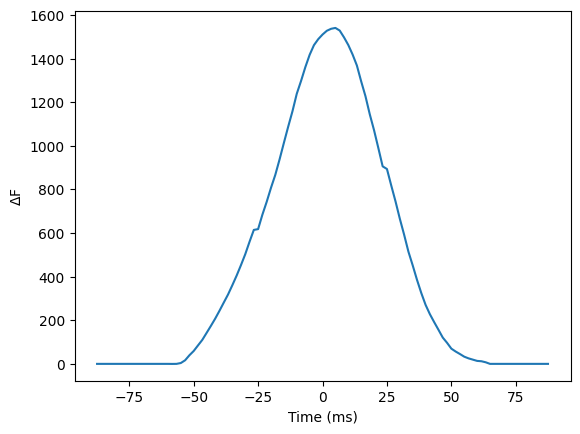

In [12]:
# Number of temporal models for sliding time window inversion
sliding_n_temp_modes = 4
# Size of sliding window (in ms)
win_size = 50
# Whether or not windows overlap
win_overlap = True

# Run sliding time window model comparison between the first layer (pial) and the last layer (white matter)
[Fs,wois] = sliding_window_model_comparison(
    prior, 
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    [layer_fnames[0], layer_fnames[-1]], 
    pial_sim_fname, 
    patch_size=patch_size, 
    n_temp_modes=sliding_n_temp_modes,
    win_size=win_size, 
    win_overlap=win_overlap,
    spm_instance=spm
)

# Plot difference in free energy over time (pial minus white) - this should be positive
plt.plot(np.mean(wois,axis=-1), Fs[0,:]-Fs[1,:])
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')

## White matter surface simulation with pial - white matter sliding time window model comparison
Let's simulate the same pattern of activity, in the same location, but on the white matter surface. This time, sliding time window model comparison should yield greater model evidence for the white matter surface, and therefore the difference in free energy (pial - white matter) should be negative.

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING DIPOLE SOURCES
computing surface normals
Setting white noise to give sensor level SNR of -10B

 Finish
Smoothing ../test_data/sub-104/surf/multilayer.11.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/sliding_window/sim_24588_white_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Ma



------------------------------------------------------------------------
13-Jul-2024 09:56:01 - Running job #1
------------------------------------------------------------------------
13-Jul-2024 09:56:01 - Running 'Source inversion, iterative'
Using 1 iterations of 1 patches
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24588_white_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldspatchiter 1/1
Checking leadfields
ans =

    0.7239    0.0699
    0.7999    0.2531

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of samples 16
Fixed number of temporal modes
Using 4 temporal modes, accounting for 67.61 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1             

  ReML Iteration              : 1                            ...1.085736e+02
  ReML Iteration              : 2                            ...8.500566e+01
  ReML Iteration              : 3                            ...7.168712e+01
  ReML Iteration              : 4                            ...6.217907e+01
  ReML Iteration              : 5                            ...5.417339e+01
  ReML Iteration              : 6                            ...4.660845e+01
  ReML Iteration              : 7                            ...3.900641e+01
  ReML Iteration              : 8                            ...3.130761e+01
  ReML Iteration              : 9                            ...2.379889e+01
  ReML Iteration              : 10                            ...1.697540e+01
  ReML Iteration              : 11                            ...1.131193e+01
  ReML Iteration              : 12                            ...7.050808e+00
  ReML Iteration              : 13                            ...4.135955

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219719e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193778e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170218e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113183e+02 [+4.50]
  ReML Iteration 5                      :        ...1.199438e-03 [+4.62]
Percent variance explained -37.18 (-21.70)
Number of samples 20
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.56 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.828792e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188150e+02 [+4.25]
  ReML Iterati

  ReML Iteration              : 7                            ...3.961558e+01
  ReML Iteration              : 8                            ...3.203463e+01
  ReML Iteration              : 9                            ...2.458753e+01
  ReML Iteration              : 10                            ...1.774734e+01
  ReML Iteration              : 11                            ...1.199310e+01
  ReML Iteration              : 12                            ...7.596253e+00
  ReML Iteration              : 13                            ...4.537515e+00
  ReML Iteration              : 14                            ...2.580687e+00
  ReML Iteration              : 15                            ...1.412963e+00
  ReML Iteration              : 16                            ...7.529913e-01
  ReML Iteration              : 17                            ...3.946370e-01
  ReML Iteration              : 18                            ...2.053366e-01
  ReML Iteration              : 19                            ...1.

Percent variance explained -17.98 (-8.40)
Number of samples 25
Fixed number of temporal modes
Using 4 temporal modes, accounting for 46.69 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.827215e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188277e+02 [+4.25]
  ReML Iteration 3                      :        ...1.131196e+02 [+4.38]
  ReML Iteration 4                      :        ...1.040033e+02 [+4.50]
  ReML Iteration 5                      :        ...8.376121e+01 [+4.62]
  ReML Iteration 6                      :        ...1.535577e-04 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
   10.95   -1.94

  ReML Iteration              : 1                            ...1.086459e

  ReML Iteration              : 7                            ...3.924767e+01
  ReML Iteration              : 8                            ...3.159473e+01
  ReML Iteration              : 9                            ...2.410919e+01
  ReML Iteration              : 10                            ...1.727775e+01
  ReML Iteration              : 11                            ...1.157727e+01
  ReML Iteration              : 12                            ...7.261904e+00
  ReML Iteration              : 13                            ...4.290150e+00
  ReML Iteration              : 14                            ...2.409402e+00
  ReML Iteration              : 15                            ...1.299961e+00
  ReML Iteration              : 16                            ...6.807690e-01
  ReML Iteration              : 17                            ...3.492591e-01
  ReML Iteration              : 18                            ...1.769537e-01
  ReML Iteration              : 19                            ...8.

  ReML Iteration 1                      :        ...5.861945e+02 [+4.12]
  ReML Iteration 2                      :        ...1.185489e+02 [+4.25]
  ReML Iteration 3                      :        ...1.122969e+02 [+4.38]
  ReML Iteration 4                      :        ...1.020235e+02 [+4.50]
  ReML Iteration 5                      :        ...7.976003e+01 [+4.62]
  ReML Iteration 6                      :        ...1.143282e-02 [+4.75]
  ReML Iteration 7                      :        ...1.384846e-09 [+4.88]
log evidence & hyperparameters:
    0.00   -0.03
   10.94   -1.91

  ReML Iteration              : 1                            ...1.085434e+02
  ReML Iteration              : 2                            ...8.493756e+01
  ReML Iteration              : 3                            ...7.156971e+01
  ReML Iteration              : 4                            ...6.199180e+01
  ReML Iteration              : 5                            ...5.389407e+01
  ReML Iteration              : 6    

  ReML Iteration              : 19                            ...6.471881e-02
  ReML Iteration              : 20                            ...3.113019e-02
  ReML Iteration              : 21                            ...1.497501e-02
  ReML Iteration              : 22                            ...7.226272e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.221128e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192450e+02 [+4.25]
  ReML Iteration 3                      :        ...1.166690e+02 [+4.38]
  ReML Iteration 4                      :        ...1.104187e+02 [+4.50]
  ReML Iteration 5                      :        ...9.595581e+01 [+4.62]
  ReML Iteration 6                      :        ...1.197575e-02 [+4.75]
  ReML Iteration 7                      :        ...1.160312e-09 [+4.88]
Percent variance explained -19.62 (-7.53)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, account

  ReML Iteration              : 1                            ...1.082700e+02
  ReML Iteration              : 2                            ...8.365713e+01
  ReML Iteration              : 3                            ...6.938014e+01
  ReML Iteration              : 4                            ...5.855654e+01
  ReML Iteration              : 5                            ...4.890148e+01
  ReML Iteration              : 6                            ...3.952728e+01
  ReML Iteration              : 7                            ...3.031768e+01
  ReML Iteration              : 8                            ...2.168745e+01
  ReML Iteration              : 9                            ...1.428694e+01
  ReML Iteration              : 10                            ...8.618728e+00
  ReML Iteration              : 11                            ...4.773560e+00
  ReML Iteration              : 12                            ...2.451900e+00
  ReML Iteration              : 13                            ...1.185736

  ReML Iteration 1                      :        ...6.905093e+02 [+4.12]
  ReML Iteration 2                      :        ...1.111658e+02 [+4.25]
  ReML Iteration 3                      :        ...9.128397e+01 [+4.38]
  ReML Iteration 4                      :        ...5.950353e+01 [+4.50]
  ReML Iteration 5                      :        ...2.075644e+01 [+4.62]
  ReML Iteration 6                      :        ...8.015083e+00 [+4.75]
  ReML Iteration 7                      :        ...6.450745e-04 [+4.88]
log evidence & hyperparameters:
    0.00   -0.00
   10.97   -0.99

  ReML Iteration              : 1                            ...1.124103e+02
  ReML Iteration              : 2                            ...7.898228e+01
  ReML Iteration              : 3                            ...6.166761e+01
  ReML Iteration              : 4                            ...4.730251e+01
  ReML Iteration              : 5                            ...3.425886e+01
  ReML Iteration              : 6    

  ReML Iteration 1                      :        ...1.156838e+03 [+4.12]
  ReML Iteration 2                      :        ...9.412427e+01 [+4.25]
  ReML Iteration 3                      :        ...4.330859e+01 [+4.38]
  ReML Iteration 4                      :        ...9.362201e+00 [+4.50]
  ReML Iteration 5                      :        ...2.950345e-01 [+4.62]
  ReML Iteration 6                      :        ...2.379348e-04 [+4.75]
log evidence & hyperparameters:
    0.00 1961.17
   10.94    0.39

  ReML Iteration              : 1                            ...2.340506e+02
  ReML Iteration              : 2                            ...6.200612e+01
  ReML Iteration              : 3                            ...3.638919e+01
  ReML Iteration              : 4                            ...1.908131e+01
  ReML Iteration              : 5                            ...8.541744e+00
  ReML Iteration              : 6                            ...3.325764e+00
  ReML Iteration              : 7

Percent variance explained 92.57 (36.71)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 40.38 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...4.156427e+03 [+4.12]
  ReML Iteration 2                      :        ...2.776524e+02 [+4.25]
  ReML Iteration 3                      :        ...3.261889e+00 [+4.38]
  ReML Iteration 4                      :        ...1.758110e-02 [+4.50]
  ReML Iteration 5                      :        ...1.038673e-06 [+4.62]
log evidence & hyperparameters:
    0.00 9609.92
   10.89    1.98

  ReML Iteration              : 1                            ...2.168252e+03
  ReML Iteration              : 2                            ...1.1945

  ReML Iteration              : 1                            ...7.488068e+03
  ReML Iteration              : 2                            ...1.065817e+03
  ReML Iteration              : 3                            ...1.366415e+02
  ReML Iteration              : 4                            ...2.111104e+01
  ReML Iteration              : 5                            ...4.036319e+00
  ReML Iteration              : 6                            ...9.144025e-01
  ReML Iteration              : 7                            ...2.356966e-01
  ReML Iteration              : 8                            ...6.711701e-02
  ReML Iteration              : 9                            ...2.067881e-02
  ReML Iteration              : 10                            ...6.791002e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.374573e+03 [+4.12]
  ReML Iteration 2                      :        ...1.081070e+03 [+4.25]
  ReML Iteration 3             

  ReML Iteration              : 1                            ...1.337680e+04
  ReML Iteration              : 2                            ...3.633113e+03
  ReML Iteration              : 3                            ...7.610018e+02
  ReML Iteration              : 4                            ...1.493598e+02
  ReML Iteration              : 5                            ...3.159472e+01
  ReML Iteration              : 6                            ...7.475896e+00
  ReML Iteration              : 7                            ...1.965737e+00
  ReML Iteration              : 8                            ...5.652139e-01
  ReML Iteration              : 9                            ...1.750110e-01
  ReML Iteration              : 10                            ...5.762776e-02
  ReML Iteration              : 11                            ...1.998093e-02
  ReML Iteration              : 12                            ...7.238447e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

Percent variance explained 97.94 (59.82)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 63.31 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.114193e+04 [+4.12]
  ReML Iteration 2                      :        ...1.117439e+04 [+4.25]
  ReML Iteration 3                      :        ...2.956969e+03 [+4.38]
  ReML Iteration 4                      :        ...2.455958e+02 [+4.50]
  ReML Iteration 5                      :        ...2.393502e+00 [+4.62]
  ReML Iteration 6                      :        ...2.749921e-04 [+4.75]
log evidence & hyperparameters:
    0.00 48452.12
   10.21    4.29

  ReML Iteration              : 1                            ...1.798951e

  ReML Iteration              : 1                            ...1.972808e+04
  ReML Iteration              : 2                            ...8.751973e+03
  ReML Iteration              : 3                            ...3.141050e+03
  ReML Iteration              : 4                            ...9.254316e+02
  ReML Iteration              : 5                            ...2.476698e+02
  ReML Iteration              : 6                            ...6.610427e+01
  ReML Iteration              : 7                            ...1.845768e+01
  ReML Iteration              : 8                            ...5.471462e+00
  ReML Iteration              : 9                            ...1.721439e+00
  ReML Iteration              : 10                            ...5.717621e-01
  ReML Iteration              : 11                            ...1.992043e-01
  ReML Iteration              : 12                            ...7.236590e-02
  ReML Iteration              : 13                            ...2.726791

  ReML Iteration              : 7                            ...3.791691e+01
  ReML Iteration              : 8                            ...1.146172e+01
  ReML Iteration              : 9                            ...3.644216e+00
  ReML Iteration              : 10                            ...1.217406e+00
  ReML Iteration              : 11                            ...4.255305e-01
  ReML Iteration              : 12                            ...1.548746e-01
  ReML Iteration              : 13                            ...5.842220e-02
  ReML Iteration              : 14                            ...2.274816e-02
  ReML Iteration              : 15                            ...9.110728e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.373002e+04 [+4.12]
  ReML Iteration 2                      :        ...1.388797e+04 [+4.25]
  ReML Iteration 3                      :        ...3.644229e+03 [+4.38]
  ReML Iteration 4            

  ReML Iteration              : 13                            ...1.060870e-01
  ReML Iteration              : 14                            ...4.133780e-02
  ReML Iteration              : 15                            ...1.656334e-02
  ReML Iteration              : 16                            ...6.804659e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.509256e+04 [+4.12]
  ReML Iteration 2                      :        ...1.606636e+04 [+4.25]
  ReML Iteration 3                      :        ...5.219451e+03 [+4.38]
  ReML Iteration 4                      :        ...3.756777e+02 [+4.50]
  ReML Iteration 5                      :        ...1.364757e+00 [+4.62]
  ReML Iteration 6                      :        ...1.594850e-05 [+4.75]
Percent variance explained 98.27 (77.49)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 79.92 percent average variance
Using 1 spatial source priors provi

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.599724e+04 [+4.12]
  ReML Iteration 2                      :        ...1.763131e+04 [+4.25]
  ReML Iteration 3                      :        ...6.580956e+03 [+4.38]
  ReML Iteration 4                      :        ...6.388997e+02 [+4.50]
  ReML Iteration 5                      :        ...4.157740e+00 [+4.62]
  ReML Iteration 6                      :        ...1.513998e-04 [+4.75]
Percent variance explained 98.29 (80.23)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 82.29 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.690398e+04 [+4.12]
  ReML Iteration

Percent variance explained 98.30 (81.89)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.67 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.733902e+04 [+4.12]
  ReML Iteration 2                      :        ...2.093984e+04 [+4.25]
  ReML Iteration 3                      :        ...1.224846e+04 [+4.38]
  ReML Iteration 4                      :        ...5.541681e+03 [+4.50]
  ReML Iteration 5                      :        ...2.696279e-06 [+4.62]
log evidence & hyperparameters:
    0.00 73847.35
    7.92    5.36

  ReML Iteration              : 1                            ...2.425112e+04
  ReML Iteration              : 2                            ...1.426

  ReML Iteration 1                      :        ...2.746083e+04 [+4.12]
  ReML Iteration 2                      :        ...2.117025e+04 [+4.25]
  ReML Iteration 3                      :        ...1.255217e+04 [+4.38]
  ReML Iteration 4                      :        ...5.826090e+03 [+4.50]
  ReML Iteration 5                      :        ...3.028419e-06 [+4.62]
log evidence & hyperparameters:
    0.00 74405.98
    7.81    5.39

  ReML Iteration              : 1                            ...2.437541e+04
  ReML Iteration              : 2                            ...1.443680e+04
  ReML Iteration              : 3                            ...7.729066e+03
  ReML Iteration              : 4                            ...3.494392e+03
  ReML Iteration              : 5                            ...1.335441e+03
  ReML Iteration              : 6                            ...4.540712e+02
  ReML Iteration              : 7                            ...1.465580e+02
  ReML Iteration            

  ReML Iteration              : 1                            ...2.427061e+04
  ReML Iteration              : 2                            ...1.428802e+04
  ReML Iteration              : 3                            ...7.580298e+03
  ReML Iteration              : 4                            ...3.389258e+03
  ReML Iteration              : 5                            ...1.281239e+03
  ReML Iteration              : 6                            ...4.319130e+02
  ReML Iteration              : 7                            ...1.386078e+02
  ReML Iteration              : 8                            ...4.443338e+01
  ReML Iteration              : 9                            ...1.459971e+01
  ReML Iteration              : 10                            ...4.968193e+00
  ReML Iteration              : 11                            ...1.754960e+00
  ReML Iteration              : 12                            ...6.426481e-01
  ReML Iteration              : 13                            ...2.433009

  ReML Iteration              : 7                            ...1.183891e+02
  ReML Iteration              : 8                            ...3.760026e+01
  ReML Iteration              : 9                            ...1.228866e+01
  ReML Iteration              : 10                            ...4.169041e+00
  ReML Iteration              : 11                            ...1.470094e+00
  ReML Iteration              : 12                            ...5.377835e-01
  ReML Iteration              : 13                            ...2.034767e-01
  ReML Iteration              : 14                            ...7.937289e-02
  ReML Iteration              : 15                            ...3.182457e-02
  ReML Iteration              : 16                            ...1.307980e-02
  ReML Iteration              : 17                            ...5.497256e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.640841e+04 [+4.12]
  ReML Iteration 2  

  ReML Iteration              : 13                            ...1.485377e-01
  ReML Iteration              : 14                            ...5.790908e-02
  ReML Iteration              : 15                            ...2.321054e-02
  ReML Iteration              : 16                            ...9.537387e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.579495e+04 [+4.12]
  ReML Iteration 2                      :        ...1.727295e+04 [+4.25]
  ReML Iteration 3                      :        ...6.251307e+03 [+4.38]
  ReML Iteration 4                      :        ...5.675714e+02 [+4.50]
  ReML Iteration 5                      :        ...3.239851e+00 [+4.62]
  ReML Iteration 6                      :        ...9.141448e-05 [+4.75]
Percent variance explained 98.29 (79.53)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 79.99 percent average variance
Using 1 spatial source priors provi

Percent variance explained 98.25 (76.36)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 76.34 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.523635e+04 [+4.12]
  ReML Iteration 2                      :        ...1.720358e+04 [+4.25]
  ReML Iteration 3                      :        ...7.871215e+03 [+4.38]
  ReML Iteration 4                      :        ...2.174053e+03 [+4.50]
  ReML Iteration 5                      :        ...3.826153e+02 [+4.62]
  ReML Iteration 6                      :        ...2.905527e-08 [+4.75]
log evidence & hyperparameters:
    0.00 63999.19
    8.44    4.91

  ReML Iteration              : 1                            ...2.211235e

  ReML Iteration 1                      :        ...2.415443e+04 [+4.12]
  ReML Iteration 2                      :        ...1.545444e+04 [+4.25]
  ReML Iteration 3                      :        ...6.175532e+03 [+4.38]
  ReML Iteration 4                      :        ...1.276996e+03 [+4.50]
  ReML Iteration 5                      :        ...1.112684e+02 [+4.62]
  ReML Iteration 6                      :        ...2.053870e+00 [+4.75]
  ReML Iteration 7                      :        ...1.183975e-03 [+4.88]
log evidence & hyperparameters:
    0.00 59272.33
    9.32    4.72

  ReML Iteration              : 1                            ...2.101719e+04
  ReML Iteration              : 2                            ...1.014869e+04
  ReML Iteration              : 3                            ...4.067536e+03
  ReML Iteration              : 4                            ...1.332712e+03
  ReML Iteration              : 5                            ...3.852015e+02
  ReML Iteration              : 6   

  ReML Iteration 6                      :        ...3.935323e-03 [+4.75]
log evidence & hyperparameters:
    0.00 51400.71
   10.06    4.41

  ReML Iteration              : 1                            ...1.889109e+04
  ReML Iteration              : 2                            ...7.914372e+03
  ReML Iteration              : 3                            ...2.644483e+03
  ReML Iteration              : 4                            ...7.306324e+02
  ReML Iteration              : 5                            ...1.872630e+02
  ReML Iteration              : 6                            ...4.878193e+01
  ReML Iteration              : 7                            ...1.344877e+01
  ReML Iteration              : 8                            ...3.960367e+00
  ReML Iteration              : 9                            ...1.241651e+00
  ReML Iteration              : 10                            ...4.116160e-01
  ReML Iteration              : 11                            ...1.432550e-01
  ReML Ite

  ReML Iteration              : 13                            ...6.733661e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.768795e+04 [+4.12]
  ReML Iteration 2                      :        ...6.550695e+03 [+4.25]
  ReML Iteration 3                      :        ...6.114689e+02 [+4.38]
  ReML Iteration 4                      :        ...3.566829e+00 [+4.50]
  ReML Iteration 5                      :        ...1.033051e-04 [+4.62]
Percent variance explained 98.02 (57.57)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.52 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.784353e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 1                            ...1.048062e+04
  ReML Iteration              : 2                            ...2.143052e+03
  ReML Iteration              : 3                            ...3.521836e+02
  ReML Iteration              : 4                            ...6.060414e+01
  ReML Iteration              : 5                            ...1.209023e+01
  ReML Iteration              : 6                            ...2.787955e+00
  ReML Iteration              : 7                            ...7.243978e-01
  ReML Iteration              : 8                            ...2.070798e-01
  ReML Iteration              : 9                            ...6.392807e-02
  ReML Iteration              : 10                            ...2.101654e-02
  ReML Iteration              : 11                            ...7.280445e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.166035e+04 [+4.12]
  ReML Iteration 2        

  ReML Iteration              : 1                            ...4.534995e+03
  ReML Iteration              : 2                            ...4.016398e+02
  ReML Iteration              : 3                            ...4.099970e+01
  ReML Iteration              : 4                            ...5.881738e+00
  ReML Iteration              : 5                            ...1.096027e+00
  ReML Iteration              : 6                            ...2.457718e-01
  ReML Iteration              : 7                            ...6.306191e-02
  ReML Iteration              : 8                            ...1.791763e-02
  ReML Iteration              : 9                            ...5.514001e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...5.120559e+03 [+4.12]
  ReML Iteration 2                      :        ...3.719882e+02 [+4.25]
  ReML Iteration 3                      :        ...7.514511e+00 [+4.38]
  ReML Iteration 4                  

  ReML Iteration              : 7                            ...1.445410e-01
  ReML Iteration              : 8                            ...4.365468e-02
  ReML Iteration              : 9                            ...1.386481e-02
  ReML Iteration              : 10                            ...4.626321e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.684057e+02 [+4.12]
  ReML Iteration 2                      :        ...8.491702e+01 [+4.25]
  ReML Iteration 3                      :        ...3.975164e+01 [+4.38]
  ReML Iteration 4                      :        ...7.194133e+00 [+4.50]
  ReML Iteration 5                      :        ...1.501856e-01 [+4.62]
  ReML Iteration 6                      :        ...4.328254e-05 [+4.75]
Percent variance explained 89.92 (35.31)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 38.59 percent average variance
Using 1 spatial source priors provided

Percent variance explained 68.94 (26.54)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 38.37 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...7.317885e+02 [+4.12]
  ReML Iteration 2                      :        ...1.087091e+02 [+4.25]
  ReML Iteration 3                      :        ...8.456693e+01 [+4.38]
  ReML Iteration 4                      :        ...4.891652e+01 [+4.50]
  ReML Iteration 5                      :        ...1.289623e+01 [+4.62]
  ReML Iteration 6                      :        ...6.592290e-01 [+4.75]
  ReML Iteration 7                      :        ...1.445566e-03 [+4.88]
log evidence & hyperparameters:
    0.00  457.80
   10.94   -0.86

 

Percent variance explained -318.62 (-122.48)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 38.46 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.027166e+02 [+4.12]
  ReML Iteration 2                      :        ...1.172540e+02 [+4.25]
  ReML Iteration 3                      :        ...1.085065e+02 [+4.38]
  ReML Iteration 4                      :        ...9.322391e+01 [+4.50]
  ReML Iteration 5                      :        ...6.344323e+01 [+4.62]
  ReML Iteration 6                      :        ...3.057254e-01 [+4.75]
  ReML Iteration 7                      :        ...9.555965e-07 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
   10.95   -1.7

  ReML Iteration              : 13                            ...3.356469e+00
  ReML Iteration              : 14                            ...1.793042e+00
  ReML Iteration              : 15                            ...9.165851e-01
  ReML Iteration              : 16                            ...4.530974e-01
  ReML Iteration              : 17                            ...2.187053e-01
  ReML Iteration              : 18                            ...1.039634e-01
  ReML Iteration              : 19                            ...4.901796e-02
  ReML Iteration              : 20                            ...2.305322e-02
  ReML Iteration              : 21                            ...1.085992e-02
  ReML Iteration              : 22                            ...5.139280e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.222142e+02 [+4.12]
  ReML Iteration 2                      :        ...1.191554e+02 [+4.25]
  ReML Iteration 3    

  ReML Iteration 1                      :        ...5.869902e+02 [+4.12]
  ReML Iteration 2                      :        ...1.184853e+02 [+4.25]
  ReML Iteration 3                      :        ...1.121097e+02 [+4.38]
  ReML Iteration 4                      :        ...1.015766e+02 [+4.50]
  ReML Iteration 5                      :        ...7.887390e+01 [+4.62]
  ReML Iteration 6                      :        ...1.652318e-02 [+4.75]
  ReML Iteration 7                      :        ...2.872303e-09 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
   10.95   -1.89

  ReML Iteration              : 1                            ...1.085223e+02
  ReML Iteration              : 2                            ...8.488766e+01
  ReML Iteration              : 3                            ...7.148373e+01
  ReML Iteration              : 4                            ...6.185487e+01
  ReML Iteration              : 5                            ...5.369030e+01
  ReML Iteration              : 6    

  ReML Iteration              : 19                            ...9.771619e-02
  ReML Iteration              : 20                            ...5.017601e-02
  ReML Iteration              : 21                            ...2.596655e-02
  ReML Iteration              : 22                            ...1.358410e-02
  ReML Iteration              : 23                            ...7.195114e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220034e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193471e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169403e+02 [+4.38]
  ReML Iteration 4                      :        ...1.111101e+02 [+4.50]
  ReML Iteration 5                      :        ...2.690461e-03 [+4.62]
Percent variance explained -312.18 (-135.22)
Number of samples 26
Fixed number of temporal modes
Using 4 temporal modes, accounting for 44.99 percent average variance
Using 1 spatial source pri

  ReML Iteration              : 7                            ...3.883377e+01
  ReML Iteration              : 8                            ...3.110282e+01
  ReML Iteration              : 9                            ...2.357847e+01
  ReML Iteration              : 10                            ...1.676172e+01
  ReML Iteration              : 11                            ...1.112555e+01
  ReML Iteration              : 12                            ...6.903589e+00
  ReML Iteration              : 13                            ...4.029336e+00
  ReML Iteration              : 14                            ...2.232424e+00
  ReML Iteration              : 15                            ...1.186210e+00
  ReML Iteration              : 16                            ...6.105324e-01
  ReML Iteration              : 17                            ...3.071099e-01
  ReML Iteration              : 18                            ...1.521430e-01
  ReML Iteration              : 19                            ...7.

  ReML Iteration 1                      :        ...5.841542e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187124e+02 [+4.25]
  ReML Iteration 3                      :        ...1.127791e+02 [+4.38]
  ReML Iteration 4                      :        ...1.031808e+02 [+4.50]
  ReML Iteration 5                      :        ...8.208396e+01 [+4.62]
  ReML Iteration 6                      :        ...2.644159e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
   10.94   -1.93

  ReML Iteration              : 1                            ...1.086016e+02
  ReML Iteration              : 2                            ...8.506587e+01
  ReML Iteration              : 3                            ...7.179103e+01
  ReML Iteration              : 4                            ...6.234505e+01
  ReML Iteration              : 5                            ...5.442159e+01
  ReML Iteration              : 6                            ...4.695551e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...8.422309e-02
  ReML Iteration              : 20                            ...4.196925e-02
  ReML Iteration              : 21                            ...2.095536e-02
  ReML Iteration              : 22                            ...1.051256e-02
  ReML Iteration              : 23                            ...5.307956e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220378e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193144e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168533e+02 [+4.38]
  ReML Iteration 4                      :        ...1.108879e+02 [+4.50]
  ReML Iteration 5                      :        ...4.942215e-03 [+4.62]
Percent variance explained -69.13 (-40.17)
Number of samples 18
Fixed number of temporal modes
Using 4 temporal modes, accounting for 60.83 percent average variance
Using 1 spatial source prior

  ReML Iteration              : 1                            ...1.086735e+02
  ReML Iteration              : 2                            ...8.521013e+01
  ReML Iteration              : 3                            ...7.204029e+01
  ReML Iteration              : 4                            ...6.274422e+01
  ReML Iteration              : 5                            ...5.502089e+01
  ReML Iteration              : 6                            ...4.779860e+01
  ReML Iteration              : 7                            ...4.056072e+01
  ReML Iteration              : 8                            ...3.317611e+01
  ReML Iteration              : 9                            ...2.584504e+01
  ReML Iteration              : 10                            ...1.900202e+01
  ReML Iteration              : 11                            ...1.312597e+01
  ReML Iteration              : 12                            ...8.528620e+00
  ReML Iteration              : 13                            ...5.247325



------------------------------------------------------------------------
13-Jul-2024 10:04:08 - Running job #1
------------------------------------------------------------------------
13-Jul-2024 10:04:08 - Running 'Source inversion, iterative'
Using 1 iterations of 1 patches
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24588_white_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldspatchiter 1/1
Checking leadfields
ans =

    0.0879    0.0925
    0.3893    0.8522

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of samples 16
Fixed number of temporal modes
Using 4 temporal modes, accounting for 67.61 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1            

  ReML Iteration              : 1                            ...1.085936e+02
  ReML Iteration              : 2                            ...8.504901e+01
  ReML Iteration              : 3                            ...7.176194e+01
  ReML Iteration              : 4                            ...6.229855e+01
  ReML Iteration              : 5                            ...5.435200e+01
  ReML Iteration              : 6                            ...4.685808e+01
  ReML Iteration              : 7                            ...3.933017e+01
  ReML Iteration              : 8                            ...3.169316e+01
  ReML Iteration              : 9                            ...2.421592e+01
  ReML Iteration              : 10                            ...1.738215e+01
  ReML Iteration              : 11                            ...1.166933e+01
  ReML Iteration              : 12                            ...7.335558e+00
  ReML Iteration              : 13                            ...4.344312

  ReML Iteration              : 25                            ...2.647467e-01
  ReML Iteration              : 26                            ...3.396037e-01
  ReML Iteration              : 27                            ...2.928732e-05
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219336e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194158e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171228e+02 [+4.38]
  ReML Iteration 4                      :        ...1.115769e+02 [+4.50]
  ReML Iteration 5                      :        ...1.763801e-04 [+4.62]
Percent variance explained -35.00 (-20.42)
Number of samples 20
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.56 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]

  ReML Iteration              : 1                            ...1.086380e+02
  ReML Iteration              : 2                            ...8.514055e+01
  ReML Iteration              : 3                            ...7.192001e+01
  ReML Iteration              : 4                            ...6.255143e+01
  ReML Iteration              : 5                            ...5.473101e+01
  ReML Iteration              : 6                            ...4.738990e+01
  ReML Iteration              : 7                            ...4.002391e+01
  ReML Iteration              : 8                            ...3.252577e+01
  ReML Iteration              : 9                            ...2.512572e+01
  ReML Iteration              : 10                            ...1.828076e+01
  ReML Iteration              : 11                            ...1.247087e+01
  ReML Iteration              : 12                            ...7.985673e+00
  ReML Iteration              : 13                            ...4.830428

  ReML Iteration              : 19                            ...1.643812e-01
  ReML Iteration              : 20                            ...1.056038e-01
  ReML Iteration              : 21                            ...8.102059e-02
  ReML Iteration              : 22                            ...8.815095e-02
  ReML Iteration              : 23                            ...1.886543e-01
  ReML Iteration              : 24                            ...4.172402e-01
  ReML Iteration              : 25                            ...6.086708e-05
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219196e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194299e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171604e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116731e+02 [+4.50]
  ReML Iteration 5                      :        ...2.862147e-05 [+4.62]
Percent variance explained -15.22 (-7

  ReML Iteration 1                      :        ...5.843730e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186948e+02 [+4.25]
  ReML Iteration 3                      :        ...1.127272e+02 [+4.38]
  ReML Iteration 4                      :        ...1.030560e+02 [+4.50]
  ReML Iteration 5                      :        ...8.183118e+01 [+4.62]
  ReML Iteration 6                      :        ...3.292127e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
   10.95   -1.48

  ReML Iteration              : 1                            ...1.085951e+02
  ReML Iteration              : 2                            ...8.505209e+01
  ReML Iteration              : 3                            ...7.176724e+01
  ReML Iteration              : 4                            ...6.230703e+01
  ReML Iteration              : 5                            ...5.436468e+01
  ReML Iteration              : 6                            ...4.687582e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...8.084311e-02
  ReML Iteration              : 20                            ...4.001291e-02
  ReML Iteration              : 21                            ...1.982816e-02
  ReML Iteration              : 22                            ...9.865063e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220482e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193045e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168272e+02 [+4.38]
  ReML Iteration 4                      :        ...1.108214e+02 [+4.50]
  ReML Iteration 5                      :        ...9.687841e+01 [+4.62]
  ReML Iteration 6                      :        ...5.760425e-03 [+4.75]
Percent variance explained -5.93 (-2.45)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 38.27 percent average variance
Using 1 spatial source priors provi

  ReML Iteration              : 1                            ...1.085342e+02
  ReML Iteration              : 2                            ...8.491599e+01
  ReML Iteration              : 3                            ...7.153253e+01
  ReML Iteration              : 4                            ...6.193256e+01
  ReML Iteration              : 5                            ...5.380587e+01
  ReML Iteration              : 6                            ...4.609680e+01
  ReML Iteration              : 7                            ...3.834652e+01
  ReML Iteration              : 8                            ...3.052779e+01
  ReML Iteration              : 9                            ...2.296364e+01
  ReML Iteration              : 10                            ...1.617053e+01
  ReML Iteration              : 11                            ...1.061483e+01
  ReML Iteration              : 12                            ...6.504697e+00
  ReML Iteration              : 13                            ...3.744268

Percent variance explained -111.24 (-43.02)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 38.86 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.074788e+02 [+4.12]
  ReML Iteration 2                      :        ...1.168903e+02 [+4.25]
  ReML Iteration 3                      :        ...1.074505e+02 [+4.38]
  ReML Iteration 4                      :        ...9.086483e+01 [+4.50]
  ReML Iteration 5                      :        ...5.946380e+01 [+4.62]
  ReML Iteration 6                      :        ...4.628960e-01 [+4.75]
  ReML Iteration 7                      :        ...2.185959e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
   10.96   -1.21

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.291177e+02 [+4.12]
  ReML Iteration 2                      :        ...1.159933e+02 [+4.25]
  ReML Iteration 3                      :        ...1.082524e+02 [+4.38]
  ReML Iteration 4                      :        ...9.037740e+01 [+4.50]
  ReML Iteration 5                      :        ...5.696895e+01 [+4.62]
  ReML Iteration 6                      :        ...3.930194e+00 [+4.75]
  ReML Iteration 7                      :        ...1.176693e-04 [+4.88]
Percent variance explained -805.56 (-314.67)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 38.88 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Itera

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.010988e+02 [+4.12]
  ReML Iteration 2                      :        ...1.057682e+02 [+4.25]
  ReML Iteration 3                      :        ...8.435198e+01 [+4.38]
  ReML Iteration 4                      :        ...4.695318e+01 [+4.50]
  ReML Iteration 5                      :        ...1.106126e+01 [+4.62]
  ReML Iteration 6                      :        ...4.162715e-01 [+4.75]
  ReML Iteration 7                      :        ...4.406724e-04 [+4.88]
Percent variance explained 71.80 (27.72)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 38.81 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration

  ReML Iteration              : 1                            ...1.393113e+03
  ReML Iteration              : 2                            ...7.311470e+01
  ReML Iteration              : 3                            ...1.243224e+01
  ReML Iteration              : 4                            ...2.858786e+00
  ReML Iteration              : 5                            ...6.857626e-01
  ReML Iteration              : 6                            ...1.735481e-01
  ReML Iteration              : 7                            ...4.717258e-02
  ReML Iteration              : 8                            ...1.378529e-02
  ReML Iteration              : 9                            ...4.302261e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.626444e+03 [+4.12]
  ReML Iteration 2                      :        ...9.016747e+01 [+4.25]
  ReML Iteration 3                      :        ...2.480503e+01 [+4.38]
  ReML Iteration 4                  

  ReML Iteration              : 7                            ...1.377243e-01
  ReML Iteration              : 8                            ...3.917128e-02
  ReML Iteration              : 9                            ...1.206125e-02
  ReML Iteration              : 10                            ...3.959638e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...6.968821e+03 [+4.12]
  ReML Iteration 2                      :        ...7.145204e+02 [+4.25]
  ReML Iteration 3                      :        ...8.308149e+00 [+4.38]
  ReML Iteration 4                      :        ...3.821822e-02 [+4.50]
  ReML Iteration 5                      :        ...1.555529e-06 [+4.62]
Percent variance explained 97.83 (43.21)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 46.05 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]

  ReML Iteration              : 7                            ...1.349748e+00
  ReML Iteration              : 8                            ...3.871137e-01
  ReML Iteration              : 9                            ...1.197082e-01
  ReML Iteration              : 10                            ...3.938999e-02
  ReML Iteration              : 11                            ...1.365213e-02
  ReML Iteration              : 12                            ...4.944624e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.362401e+04 [+4.12]
  ReML Iteration 2                      :        ...3.429438e+03 [+4.25]
  ReML Iteration 3                      :        ...1.413500e+02 [+4.38]
  ReML Iteration 4                      :        ...1.716413e-01 [+4.50]
  ReML Iteration 5                      :        ...2.298816e-07 [+4.62]
Percent variance explained 98.84 (51.43)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration 1                      :        ...2.060091e+04 [+4.12]
  ReML Iteration 2                      :        ...1.049413e+04 [+4.25]
  ReML Iteration 3                      :        ...2.563600e+03 [+4.38]
  ReML Iteration 4                      :        ...1.781401e+02 [+4.50]
  ReML Iteration 5                      :        ...1.152933e+00 [+4.62]
  ReML Iteration 6                      :        ...5.557467e-05 [+4.75]
log evidence & hyperparameters:
    0.00 46773.12
   10.24    4.62

  ReML Iteration              : 1                            ...1.744950e+04
  ReML Iteration              : 2                            ...6.593979e+03
  ReML Iteration              : 3                            ...1.948793e+03
  ReML Iteration              : 4                            ...4.859638e+02
  ReML Iteration              : 5                            ...1.168270e+02
  ReML Iteration              : 6                            ...2.941156e+01
  ReML Iteration              : 

  ReML Iteration              : 7                            ...2.213777e+01
  ReML Iteration              : 8                            ...6.590625e+00
  ReML Iteration              : 9                            ...2.078312e+00
  ReML Iteration              : 10                            ...6.911605e-01
  ReML Iteration              : 11                            ...2.409729e-01
  ReML Iteration              : 12                            ...8.757488e-02
  ReML Iteration              : 13                            ...3.300663e-02
  ReML Iteration              : 14                            ...1.284527e-02
  ReML Iteration              : 15                            ...5.142940e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.228908e+04 [+4.12]
  ReML Iteration 2                      :        ...1.180695e+04 [+4.25]
  ReML Iteration 3                      :        ...2.455702e+03 [+4.38]
  ReML Iteration 4            

  ReML Iteration              : 13                            ...6.007482e-02
  ReML Iteration              : 14                            ...2.339234e-02
  ReML Iteration              : 15                            ...9.368893e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.379704e+04 [+4.12]
  ReML Iteration 2                      :        ...1.399025e+04 [+4.25]
  ReML Iteration 3                      :        ...3.710330e+03 [+4.38]
  ReML Iteration 4                      :        ...1.740911e+02 [+4.50]
  ReML Iteration 5                      :        ...2.769979e-01 [+4.62]
  ReML Iteration 6                      :        ...6.410971e-07 [+4.75]
Percent variance explained 99.55 (72.85)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 74.79 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
 

Percent variance explained 99.62 (77.34)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 78.85 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.650858e+04 [+4.12]
  ReML Iteration 2                      :        ...1.941008e+04 [+4.25]
  ReML Iteration 3                      :        ...1.033152e+04 [+4.38]
  ReML Iteration 4                      :        ...3.891395e+03 [+4.50]
  ReML Iteration 5                      :        ...9.074749e-07 [+4.62]
log evidence & hyperparameters:
    0.00 70004.64
    8.49    5.51

  ReML Iteration              : 1                            ...2.340485e+04
  ReML Iteration              : 2                            ...1.309

  ReML Iteration 1                      :        ...2.734667e+04 [+4.12]
  ReML Iteration 2                      :        ...2.095426e+04 [+4.25]
  ReML Iteration 3                      :        ...1.226736e+04 [+4.38]
  ReML Iteration 4                      :        ...5.559205e+03 [+4.50]
  ReML Iteration 5                      :        ...2.716644e-06 [+4.62]
log evidence & hyperparameters:
    0.00 73882.47
    7.79    5.68

  ReML Iteration              : 1                            ...2.425892e+04
  ReML Iteration              : 2                            ...1.427149e+04
  ReML Iteration              : 3                            ...7.563864e+03
  ReML Iteration              : 4                            ...3.377736e+03
  ReML Iteration              : 5                            ...1.275347e+03
  ReML Iteration              : 6                            ...4.295201e+02
  ReML Iteration              : 7                            ...1.377532e+02
  ReML Iteration            

  ReML Iteration              : 1                            ...2.482513e+04
  ReML Iteration              : 2                            ...1.508673e+04
  ReML Iteration              : 3                            ...8.398113e+03
  ReML Iteration              : 4                            ...3.985637e+03
  ReML Iteration              : 5                            ...1.599100e+03
  ReML Iteration              : 6                            ...5.655769e+02
  ReML Iteration              : 7                            ...1.875303e+02
  ReML Iteration              : 8                            ...6.133110e+01
  ReML Iteration              : 9                            ...2.038817e+01
  ReML Iteration              : 10                            ...6.984614e+00
  ReML Iteration              : 11                            ...2.476806e+00
  ReML Iteration              : 12                            ...9.090366e-01
  ReML Iteration              : 13                            ...3.446169

  ReML Iteration              : 1                            ...2.505488e+04
  ReML Iteration              : 2                            ...1.542597e+04
  ReML Iteration              : 3                            ...8.759853e+03
  ReML Iteration              : 4                            ...4.263885e+03
  ReML Iteration              : 5                            ...1.755986e+03
  ReML Iteration              : 6                            ...6.347774e+02
  ReML Iteration              : 7                            ...2.137307e+02
  ReML Iteration              : 8                            ...7.057560e+01
  ReML Iteration              : 9                            ...2.359520e+01
  ReML Iteration              : 10                            ...8.110002e+00
  ReML Iteration              : 11                            ...2.881394e+00
  ReML Iteration              : 12                            ...1.058718e+00
  ReML Iteration              : 13                            ...4.016303

  ReML Iteration              : 1                            ...2.501636e+04
  ReML Iteration              : 2                            ...1.536876e+04
  ReML Iteration              : 3                            ...8.698236e+03
  ReML Iteration              : 4                            ...4.215859e+03
  ReML Iteration              : 5                            ...1.728520e+03
  ReML Iteration              : 6                            ...6.225117e+02
  ReML Iteration              : 7                            ...2.090451e+02
  ReML Iteration              : 8                            ...6.891286e+01
  ReML Iteration              : 9                            ...2.301640e+01
  ReML Iteration              : 10                            ...7.906489e+00
  ReML Iteration              : 11                            ...2.808144e+00
  ReML Iteration              : 12                            ...1.031600e+00
  ReML Iteration              : 13                            ...3.912968

  ReML Iteration              : 1                            ...2.477998e+04
  ReML Iteration              : 2                            ...1.502064e+04
  ReML Iteration              : 3                            ...8.328645e+03
  ReML Iteration              : 4                            ...3.933222e+03
  ReML Iteration              : 5                            ...1.570155e+03
  ReML Iteration              : 6                            ...5.530392e+02
  ReML Iteration              : 7                            ...1.828453e+02
  ReML Iteration              : 8                            ...5.969191e+01
  ReML Iteration              : 9                            ...1.982237e+01
  ReML Iteration              : 10                            ...6.786650e+00
  ReML Iteration              : 11                            ...2.405758e+00
  ReML Iteration              : 12                            ...8.827780e-01
  ReML Iteration              : 13                            ...3.346210

  ReML Iteration              : 7                            ...1.396063e+02
  ReML Iteration              : 8                            ...4.477323e+01
  ReML Iteration              : 9                            ...1.471512e+01
  ReML Iteration              : 10                            ...5.008195e+00
  ReML Iteration              : 11                            ...1.769239e+00
  ReML Iteration              : 12                            ...6.479084e-01
  ReML Iteration              : 13                            ...2.452995e-01
  ReML Iteration              : 14                            ...9.572398e-02
  ReML Iteration              : 15                            ...3.838958e-02
  ReML Iteration              : 16                            ...1.578031e-02
  ReML Iteration              : 17                            ...6.632856e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.675320e+04 [+4.12]
  ReML Iteration 2  

  ReML Iteration              : 13                            ...1.543422e-01
  ReML Iteration              : 14                            ...6.017594e-02
  ReML Iteration              : 15                            ...2.412008e-02
  ReML Iteration              : 16                            ...9.911368e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.587190e+04 [+4.12]
  ReML Iteration 2                      :        ...1.740869e+04 [+4.25]
  ReML Iteration 3                      :        ...6.374901e+03 [+4.38]
  ReML Iteration 4                      :        ...5.937282e+02 [+4.50]
  ReML Iteration 5                      :        ...3.562223e+00 [+4.62]
  ReML Iteration 6                      :        ...1.107433e-04 [+4.75]
Percent variance explained 99.62 (78.63)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 77.72 percent average variance
Using 1 spatial source priors provi

Percent variance explained 99.60 (74.74)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 73.43 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.530696e+04 [+4.12]
  ReML Iteration 2                      :        ...1.732175e+04 [+4.25]
  ReML Iteration 3                      :        ...7.993881e+03 [+4.38]
  ReML Iteration 4                      :        ...2.248258e+03 [+4.50]
  ReML Iteration 5                      :        ...4.130601e+02 [+4.62]
  ReML Iteration 6                      :        ...1.109833e-08 [+4.75]
log evidence & hyperparameters:
    0.00 64336.47
    8.25    5.27

  ReML Iteration              : 1                            ...2.218395e

  ReML Iteration 1                      :        ...2.335479e+04 [+4.12]
  ReML Iteration 2                      :        ...1.423500e+04 [+4.25]
  ReML Iteration 3                      :        ...5.125306e+03 [+4.38]
  ReML Iteration 4                      :        ...8.439684e+02 [+4.50]
  ReML Iteration 5                      :        ...4.205824e+01 [+4.62]
  ReML Iteration 6                      :        ...1.923902e-01 [+4.75]
  ReML Iteration 7                      :        ...5.070777e-06 [+4.88]
log evidence & hyperparameters:
    0.00 56108.46
    9.65    4.99

  ReML Iteration              : 1                            ...2.021028e+04
  ReML Iteration              : 2                            ...9.259031e+03
  ReML Iteration              : 3                            ...3.462993e+03
  ReML Iteration              : 4                            ...1.060526e+03
  ReML Iteration              : 5                            ...2.916552e+02
  ReML Iteration              : 6   

  ReML Iteration              : 1                            ...1.750018e+04
  ReML Iteration              : 2                            ...6.637843e+03
  ReML Iteration              : 3                            ...1.970224e+03
  ReML Iteration              : 4                            ...4.929981e+02
  ReML Iteration              : 5                            ...1.187613e+02
  ReML Iteration              : 6                            ...2.993027e+01
  ReML Iteration              : 7                            ...8.113826e+00
  ReML Iteration              : 8                            ...2.368837e+00
  ReML Iteration              : 9                            ...7.393149e-01
  ReML Iteration              : 10                            ...2.444851e-01
  ReML Iteration              : 11                            ...8.497114e-02
  ReML Iteration              : 12                            ...3.082441e-02
  ReML Iteration              : 13                            ...1.160519

Percent variance explained 99.10 (53.72)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.94 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.535037e+04 [+4.12]
  ReML Iteration 2                      :        ...5.179700e+03 [+4.25]
  ReML Iteration 3                      :        ...5.195581e+02 [+4.38]
  ReML Iteration 4                      :        ...5.174916e+00 [+4.50]
  ReML Iteration 5                      :        ...5.251144e-04 [+4.62]
log evidence & hyperparameters:
    0.00 32975.51
   10.63    4.03

  ReML Iteration              : 1                            ...1.228301e+04
  ReML Iteration              : 2                            ...3.014

Percent variance explained 98.28 (45.04)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 43.92 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...8.602947e+03 [+4.12]
  ReML Iteration 2                      :        ...1.339033e+03 [+4.25]
  ReML Iteration 3                      :        ...2.642212e+01 [+4.38]
  ReML Iteration 4                      :        ...9.396553e-03 [+4.50]
log evidence & hyperparameters:
    0.00 18721.43
   10.82    3.23

  ReML Iteration              : 1                            ...5.944896e+03
  ReML Iteration              : 2                            ...6.730172e+02
  ReML Iteration              : 3                            ...7

  ReML Iteration              : 1                            ...1.342314e+03
  ReML Iteration              : 2                            ...7.092963e+01
  ReML Iteration              : 3                            ...1.256605e+01
  ReML Iteration              : 4                            ...2.961772e+00
  ReML Iteration              : 5                            ...7.196496e-01
  ReML Iteration              : 6                            ...1.832965e-01
  ReML Iteration              : 7                            ...4.998083e-02
  ReML Iteration              : 8                            ...1.462937e-02
  ReML Iteration              : 9                            ...4.569484e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.569251e+03 [+4.12]
  ReML Iteration 2                      :        ...8.906174e+01 [+4.25]
  ReML Iteration 3                      :        ...2.557815e+01 [+4.38]
  ReML Iteration 4                  

  ReML Iteration 1                      :        ...8.659745e+02 [+4.12]
  ReML Iteration 2                      :        ...1.022007e+02 [+4.25]
  ReML Iteration 3                      :        ...6.708871e+01 [+4.38]
  ReML Iteration 4                      :        ...2.727479e+01 [+4.50]
  ReML Iteration 5                      :        ...3.246067e+00 [+4.62]
  ReML Iteration 6                      :        ...3.301616e-02 [+4.75]
  ReML Iteration 7                      :        ...3.420445e-06 [+4.88]
log evidence & hyperparameters:
    0.00  952.67
   10.94    0.19

  ReML Iteration              : 1                            ...1.422869e+02
  ReML Iteration              : 2                            ...7.107415e+01
  ReML Iteration              : 3                            ...4.950043e+01
  ReML Iteration              : 4                            ...3.212336e+01
  ReML Iteration              : 5                            ...1.852232e+01
  ReML Iteration              : 6    

  ReML Iteration 1                      :        ...6.214165e+02 [+4.12]
  ReML Iteration 2                      :        ...1.158492e+02 [+4.25]
  ReML Iteration 3                      :        ...1.044482e+02 [+4.38]
  ReML Iteration 4                      :        ...8.437419e+01 [+4.50]
  ReML Iteration 5                      :        ...4.933974e+01 [+4.62]
  ReML Iteration 6                      :        ...1.103790e+00 [+4.75]
  ReML Iteration 7                      :        ...1.237743e-05 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
   10.95   -1.08

  ReML Iteration              : 1                            ...1.084081e+02
  ReML Iteration              : 2                            ...8.279907e+01
  ReML Iteration              : 3                            ...6.793195e+01
  ReML Iteration              : 4                            ...5.634348e+01
  ReML Iteration              : 5                            ...4.581616e+01
  ReML Iteration              : 6    

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.226835e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187877e+02 [+4.25]
  ReML Iteration 3                      :        ...1.154596e+02 [+4.38]
  ReML Iteration 4                      :        ...1.073720e+02 [+4.50]
  ReML Iteration 5                      :        ...8.916122e+01 [+4.62]
  ReML Iteration 6                      :        ...1.352861e-01 [+4.75]
  ReML Iteration 7                      :        ...1.427777e-07 [+4.88]
Percent variance explained -105.97 (-40.82)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 38.70 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iterat

  ReML Iteration              : 7                            ...3.763983e+01
  ReML Iteration              : 8                            ...2.970156e+01
  ReML Iteration              : 9                            ...2.209082e+01
  ReML Iteration              : 10                            ...1.534357e+01
  ReML Iteration              : 11                            ...9.912771e+00
  ReML Iteration              : 12                            ...5.967357e+00
  ReML Iteration              : 13                            ...3.369190e+00
  ReML Iteration              : 14                            ...1.801118e+00
  ReML Iteration              : 15                            ...9.213803e-01
  ReML Iteration              : 16                            ...4.557930e-01
  ReML Iteration              : 17                            ...2.201559e-01
  ReML Iteration              : 18                            ...1.047184e-01
  ReML Iteration              : 19                            ...4.

Percent variance explained -321.60 (-134.29)
Number of samples 27
Fixed number of temporal modes
Using 4 temporal modes, accounting for 43.32 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.840823e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187182e+02 [+4.25]
  ReML Iteration 3                      :        ...1.127961e+02 [+4.38]
  ReML Iteration 4                      :        ...1.032219e+02 [+4.50]
  ReML Iteration 5                      :        ...8.216717e+01 [+4.62]
  ReML Iteration 6                      :        ...2.446796e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
   10.95   -1.47

  ReML Iteration              : 1                            ...1.0860

  ReML Iteration              : 14                            ...2.289410e+00
  ReML Iteration              : 15                            ...1.222508e+00
  ReML Iteration              : 16                            ...6.326856e-01
  ReML Iteration              : 17                            ...3.202066e-01
  ReML Iteration              : 18                            ...1.597076e-01
  ReML Iteration              : 19                            ...7.900599e-02
  ReML Iteration              : 20                            ...3.896451e-02
  ReML Iteration              : 21                            ...1.923357e-02
  ReML Iteration              : 22                            ...9.529225e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220543e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192989e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168121e+02 [+4.38]
  ReML Iteration 4         

  ReML Iteration              : 1                            ...1.086153e+02
  ReML Iteration              : 2                            ...8.509446e+01
  ReML Iteration              : 3                            ...7.184040e+01
  ReML Iteration              : 4                            ...6.242400e+01
  ReML Iteration              : 5                            ...5.453986e+01
  ReML Iteration              : 6                            ...4.712132e+01
  ReML Iteration              : 7                            ...3.967289e+01
  ReML Iteration              : 8                            ...3.210337e+01
  ReML Iteration              : 9                            ...2.466259e+01
  ReML Iteration              : 10                            ...1.782142e+01
  ReML Iteration              : 11                            ...1.205910e+01
  ReML Iteration              : 12                            ...7.649720e+00
  ReML Iteration              : 13                            ...4.577427

Percent variance explained -75.80 (-41.83)
Number of samples 19
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.11 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.847757e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186625e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126319e+02 [+4.38]
  ReML Iteration 4                      :        ...1.028266e+02 [+4.50]
  ReML Iteration 5                      :        ...8.136808e+01 [+4.62]
  ReML Iteration 6                      :        ...4.670192e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
   10.94   -1.48

  ReML Iteration              : 1                            ...1.085833

  ReML Iteration              : 15                            ...1.618183e+00
  ReML Iteration              : 16                            ...8.909269e-01
  ReML Iteration              : 17                            ...4.880146e-01
  ReML Iteration              : 18                            ...2.707344e-01
  ReML Iteration              : 19                            ...1.558537e-01
  ReML Iteration              : 20                            ...9.660293e-02
  ReML Iteration              : 21                            ...6.854169e-02
  ReML Iteration              : 22                            ...6.217385e-02
  ReML Iteration              : 23                            ...8.952110e-02
  ReML Iteration              : 24                            ...2.678575e-01
  ReML Iteration              : 25                            ...3.535518e-01
  ReML Iteration              : 26                            ...4.043932e-05
Inverting subject 1

ans =

   240


ans =

   274

  ReML Itera

13-Jul-2024 10:11:45 - Done    'Source inversion, iterative'
13-Jul-2024 10:11:45 - Done



Text(0, 0.5, '$\\Delta$F')

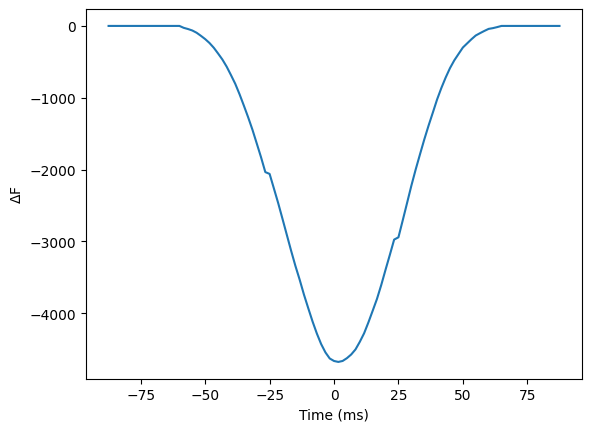

In [13]:
# Simulate at the corresponding vertex on the white matter surface
white_vertex = (n_layers-1)*verts_per_surf+sim_vertex
prefix = f'sim_{sim_vertex}_white_'

# Generate simulated data
white_sim_fname = run_dipole_simulation(
    base_fname, 
    prefix, 
    white_vertex, 
    sim_signal, 
    pial_unit_norm, 
    dipole_moment, 
    sim_patch_size, 
    SNR,
    spm_instance=spm
) 

# Localizer
[_,_,MU] = invert_ebb(
    multilayer_mesh_fname, 
    white_sim_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    return_mu_matrix=True,
    spm_instance=spm
)

layer_vertices = np.arange(verts_per_surf)
layer_ts, time, _ = load_source_time_series(
    white_sim_fname, 
    mu_matrix=MU, 
    vertices=layer_vertices
)

# Layer peak
m_layer_max = np.max(np.mean(layer_ts,axis=-1),-1)
prior = np.argmax(m_layer_max)
prior_coord = ds_inflated.darrays[0].data[prior,:]

print(f'Simulated vertex={sim_vertex}, Prior vertex={prior}')
print('Simulated coordinate')
print(sim_coord)
print('Prior coordinate')
print(prior_coord)

# Run sliding time window model comparison between the first layer (pial) and the last layer (white matter)
[Fs,wois] = sliding_window_model_comparison(
    prior, 
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    [layer_fnames[0], layer_fnames[-1]], 
    white_sim_fname, 
    patch_size=patch_size, 
    n_temp_modes=sliding_n_temp_modes,
    win_size=win_size, 
    win_overlap=win_overlap,
    spm_instance=spm
)

# Plot difference in free energy over time (pial minus white) - this should be negative
plt.plot(np.mean(wois,axis=-1), Fs[0,:]-Fs[1,:])
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')

## Simulation in each layer with sliding time window model comparison across layers
That was sliding time window model comparison with two candidate models: one based on the white matter surface, and one on the pial. Let's now simulate on each layer, and for each simulation, run sliding time window model comparison across all layers. We'll turn off SPM visualization here.

In [ ]:
# Now simulate at the corresponding vertex on each layer, and for each simulation, run sliding window model 
# comparison across all layers
all_layerF = []
for l in range(n_layers):
    print(f'Simulating in layer {l}')
    l_vertex = l*verts_per_surf+sim_vertex
    prefix = f'sim_{sim_vertex}{l}_'
    
    l_sim_fname = run_dipole_simulation(
        base_fname, 
        prefix, 
        l_vertex, 
        sim_signal, 
        pial_unit_norm, 
        dipole_moment, 
        sim_patch_size, 
        SNR, 
        spm_instance=spm
    ) 
    
    # Localizer
    [_,_,MU] = invert_ebb(
        multilayer_mesh_fname, 
        l_sim_fname, 
        n_layers, 
        patch_size=patch_size, 
        n_temp_modes=n_temp_modes,
        return_mu_matrix=True,
        spm_instance=spm
    )

    layer_vertices = np.arange(verts_per_surf)
    layer_ts, time, _ = load_source_time_series(
        l_sim_fname, 
        mu_matrix=MU, 
        vertices=layer_vertices
    )

    # Layer peak
    m_layer_max = np.max(np.mean(layer_ts,axis=-1),-1)
    prior = np.argmax(m_layer_max)    
    prior_coord = ds_inflated.darrays[0].data[prior,:]

    print(f'Simulated vertex={sim_vertex}, Prior vertex={prior}')
    print('Simulated coordinate')
    print(sim_coord)
    print('Prior coordinate')
    print(prior_coord)

    [Fs,wois] = sliding_window_model_comparison(
        prior, 
        nas, 
        lpa, 
        rpa, 
        mri_fname, 
        layer_fnames, 
        l_sim_fname, 
        patch_size=patch_size, 
        n_temp_modes=sliding_n_temp_modes,
        win_size=win_size, 
        win_overlap=win_overlap,
        viz=False,
        spm_instance=spm
    )
    
    all_layerF.append(Fs)
all_layerF = np.squeeze(np.array(all_layerF))

For each simulation, we can plot the free energy for all models relative to the worst model within a central time window. The layer model with the highest free energy should correspond to the layer that the activity was simulated in.

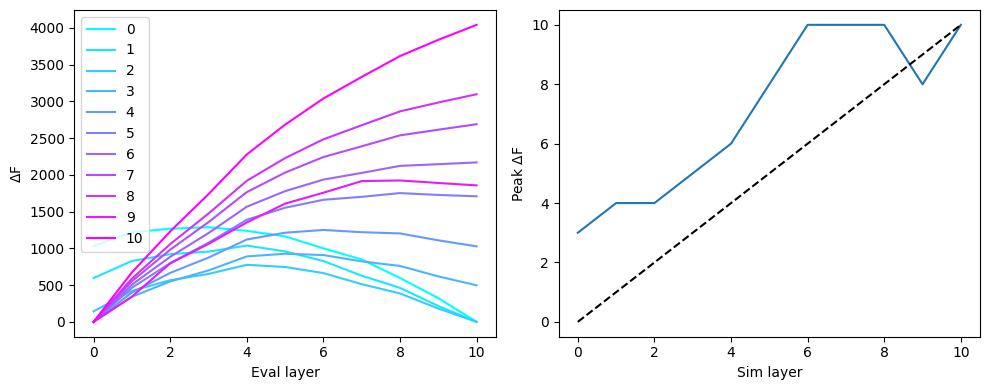

In [15]:
# Average free energy within small time window in center of the epoch
woi_t = np.mean(wois,axis=-1)
woi_idx = np.where((woi_t>=-20) & (woi_t<=20))[0]
m_all_layerF = np.mean(all_layerF[:,:,woi_idx],axis=2)

col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))

# For each simulation, plot the mean free energy of each layer model relative to that of the worst
# model for that simulation
plt.subplot(1,2,1)
for l in range(n_layers):
    layerF = m_all_layerF[l,:]
    plt.plot(layerF-np.min(layerF), label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Eval layer')
plt.ylabel(r'$\Delta$F')

# For each simulation, find which layer model had the greatest free energy
plt.subplot(1,2,2)
peaks=[]
for l in range(n_layers):
    layerF = m_all_layerF[l,:]
    layerF = layerF-np.min(layerF)
    pk = np.argmax(layerF)
    peaks.append(pk)
plt.plot(peaks)
plt.xlim([-0.5,10.5])
plt.ylim([-0.5,10.5])
plt.plot([0,10],[0,10],'k--')
plt.xlabel('Sim layer')
plt.ylabel(r'Peak $\Delta$F')
plt.tight_layout()

In [16]:
spm.terminate()

# Delete simulation files

# Iterate over all items in the directory
for item in os.listdir(tmp_dir):
    item_path = os.path.join(tmp_dir, item)

    # Check if it's a file or a directory
    if os.path.isfile(item_path):
        # Delete the file
        os.remove(item_path)
    elif os.path.isdir(item_path):
        # Recursively delete the directory
        shutil.rmtree(item_path)